<a href="https://colab.research.google.com/github/mariafelecann/LicentaAI/blob/final/word2vec_incerc_iara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas scikit-learn spacy imbalanced-learn nrclex numpy

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=7b6c9f39f1e97edf3175bec73513846a4bdfbf31594b3853bdd0f8f318770a19
  Stored in directory: /root/.cache/pip/wheels/ed/ac/fa/7afddefd14f51c4a963ed291b9052746ed3929473e5a33118d
Successfully built nrclex


In [ ]:
!python -m spacy download ro_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 59.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ro_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


In [ ]:
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from tabulate import tabulate
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MinMaxScaler


In [ ]:
import spacy

In [ ]:
!pip install joblib

In [ ]:
import joblib

In [ ]:
df = pd.read_csv('romanian_music_ultimate.csv')
print(df.columns)
if 'index' in df.columns:
    df.drop(['index'], axis=1, inplace=True)

df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

print(df['tag'].value_counts())
print(df.head())

Index(['lyrics_cleaned', 'word_count_normalized', 'repetition_score', 'tag'], dtype='object')
tag
rap        4925
pop        2318
rock        430
country     392
Name: count, dtype: int64
                                      lyrics_cleaned  word_count_normalized  \
0  foaie verde lipan foaie verde lipan of of păsc...              -0.858908   
1  putea alege loc lume trăiest viață părinte vec...              -0.662948   
2  măi bărba cumint măi bărba cumint cânepa vinde...              -1.122441   
3  frunzuliță iasomie horă plăcea micuț jucat mum...              -1.514361   
4  deal bade șesu deal bade șesu cunosc mersu cun...              -1.352187   

   repetition_score      tag  
0          0.660194  country  
1          0.509091  country  
2          0.636364  country  
3          0.204082  country  
4          0.521739  country  


In [ ]:
# nlp = spacy.load("ro_core_news_sm")
# def lemmatize_text(text):
#     doc = nlp(text)
#     return " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])
# df['lyrics_cleaned'] = df['lyrics_cleaned'].astype(str).apply(lemmatize_text)

In [ ]:
print(df['lyrics_cleaned'])

0       foaie verde lipan foaie verde lipan of of păsc...
1       putea alege loc lume trăiest viață părinte vec...
2       măi bărba cumint măi bărba cumint cânepa vinde...
3       frunzuliță iasomie horă plăcea micuț jucat mum...
4       deal bade șesu deal bade șesu cunosc mersu cun...
                              ...                        
8060    foaie verde solzi pată părint crete apte copil...
8061    constantine constantine mir uita noaptea pădur...
8062    cal bălan cal bălan verde ine pierde cal bălan...
8063    lume lăcomos ban om lailailalalalală ban chelt...
8064    veni voie hai seara petrece împreună hai seara...
Name: lyrics_cleaned, Length: 8065, dtype: object


In [ ]:
# df['lyrics_cleaned'] = df['lyrics_cleaned'].str.replace('bis', '')

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import pandas as pd
import numpy as np

X = df[['lyrics_cleaned', 'repetition_score', 'word_count_normalized']]
y = df['tag']

tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(X['lyrics_cleaned'])

def preprocessor(X):
    X_text_transformed = tfidf.transform(X['lyrics_cleaned'])

    X_combined = hstack([X_text_transformed,
                         np.array(X['word_count_normalized']).reshape(-1, 1),
                         np.array(X['repetition_score']).reshape(-1, 1)])

    return X_combined


X_tfidf = preprocessor(X)

target_size = 1000

undersample = RandomUnderSampler(sampling_strategy={'rap': target_size, 'pop': target_size}, random_state=42)
X_under, y_under = undersample.fit_resample(X_tfidf, y)

smote = SMOTE(sampling_strategy={'rock': target_size, 'country': target_size}, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_under, y_under)

X_balanced_text = X_balanced[:, :-2]


word_count_normalized = X_balanced[:, -2].toarray().flatten()
repetition_score = X_balanced[:, -1].toarray().flatten()

df_balanced = pd.DataFrame({
    'lyrics': [' '.join(words) for words in tfidf.inverse_transform(X_balanced_text)],
    'tag': y_balanced,
    'repetition_score': repetition_score,
    'word_count_normalized': word_count_normalized
})

print(df_balanced.head())
print(df_balanced['tag'].value_counts())


                                              lyrics      tag  \
0  cal casă deal des doamn doamne duce foaie greu...  country   
1  alege bun casă crede crește cântec drag drum f...  country   
2  băut cap cumint duminică durea horă iaca joi l...  country   
3  acasă babă cânta drag fac fată fiindcă flăcău ...  country   
4  altu badă cunosc deal dragoste gândesc hârtie ...  country   

   repetition_score  word_count_normalized  
0          0.660194              -0.858908  
1          0.509091              -0.662948  
2          0.636364              -1.122441  
3          0.204082              -1.514361  
4          0.521739              -1.352187  
tag
country    1000
pop        1000
rap        1000
rock       1000
Name: count, dtype: int64


In [ ]:
rock_music = df_balanced[df_balanced['tag'] == 'rock']
rock_music.head()


lyrics   tag  \
2392  alerga amintire cer curge cădea dor dragoste g...  rock   
2393  an apus baby casă cunoscut duce esti feri foc ...  rock   
2394  aci afla arată argint ascuns bun cer ciudat de...  rock   
2395  alb albastru aprins armat armată bolnav cer co...  rock   
2396  aminti an ascult chitar duce dulce gândi mamă ...  rock   

      repetition_score  word_count_normalized  
2392          0.430769              -1.068383  
2393          0.314286              -0.953509  
2394          0.211765              -0.757549  
2395          0.218487              -0.892694  
2396          0.542169              -0.994053

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313504 sha256=79f5440202219383cd8e7096dad0a78b12911bdd79e5652d46d7ecb3c357dc95
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ro.300.bin.gz
!gunzip cc.ro.300.bin.gz

--2025-05-09 09:32:11--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ro.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.96, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4508185279 (4.2G) [application/octet-stream]
Saving to: ‘cc.ro.300.bin.gz’

cc.ro.300.bin.gz    100%[===================>]   4.20G   135MB/s    in 42s     

2025-05-09 09:32:54 (102 MB/s) - ‘cc.ro.300.bin.gz’ saved [4508185279/4508185279]



In [ ]:
import fasttext
import numpy as np

FASTTEXT_RO_PATH = "cc.ro.300.bin"

def load_fasttext_vectors(model, vocab):
    fasttext_vectors = {}
    for word in vocab:
        vector = model.get_word_vector(word)
        fasttext_vectors[word] = vector
    return fasttext_vectors

all_words = set(w for lyrics in df_balanced['lyrics'] for w in lyrics.split())

model = fasttext.load_model(FASTTEXT_RO_PATH)

fasttext_ro = load_fasttext_vectors(model, all_words)

print(f"Loaded {len(fasttext_ro)} word vectors for Romanian.")


Loaded 4958 word vectors for Romanian.


In [ ]:
# from sklearn.model_selection import StratifiedKFold
# class RomanianMeanEmbeddingVectorizer:
#     def __init__(self, word2vec):
#         self.word2vec = word2vec
#         self.dim = len(next(iter(word2vec.values())))

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return np.array([
#             np.mean([self.word2vec[w] for w in words.split() if w in self.word2vec]
#                     or [np.zeros(self.dim)], axis=0)
#             for words in X
#         ])

# class RomanianTfidfEmbeddingVectorizer:
#     def __init__(self, word2vec):
#         self.word2vec = word2vec
#         self.dim = len(next(iter(word2vec.values())))
#         self.word2weight = None

#     def fit(self, X, y=None):
#         tfidf = TfidfVectorizer(analyzer='word')
#         tfidf.fit(X)
#         max_idf = max(tfidf.idf_)
#         self.word2weight = defaultdict(lambda: max_idf,
#                                      [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
#         return self

#     def transform(self, X):
#         return np.array([
#             np.mean([self.word2vec[w] * self.word2weight[w]
#                      for w in words.split() if w in self.word2vec] or
#                     [np.zeros(self.dim)], axis=0)
#             for words in X
#         ])

# X = df_balanced[['lyrics', 'repetition_score', 'word_count_normalized']]
# y = df_balanced['tag']


# pipelines = {
#     'nb': Pipeline([('count', CountVectorizer(analyzer='word')), ('clf', MultinomialNB())]),
#     'nb_tfidf': Pipeline([('tfidf', TfidfVectorizer(analyzer='word')), ('clf', MultinomialNB())]),
#     'svm': Pipeline([('count', CountVectorizer(analyzer='word')), ('clf', SVC(kernel='linear'))]),
#     'svm_tfidf': Pipeline([('tfidf', TfidfVectorizer(analyzer='word')), ('clf', SVC(kernel='linear'))]),
#     'ft_mean': Pipeline([('vectorizer', RomanianMeanEmbeddingVectorizer(fasttext_ro)),
#                         ('clf', ExtraTreesClassifier(n_estimators=200))]),
#     'ft_tfidf': Pipeline([('vectorizer', RomanianTfidfEmbeddingVectorizer(fasttext_ro)),
#                          ('clf', ExtraTreesClassifier(n_estimators=200))])
# }

# # Evaluate models
# results = []
# for name, pipeline in pipelines.items():
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     score = cross_val_score(pipeline, X, y, cv=cv).mean()

#     results.append((name, score))

# print(tabulate(results, headers=['Model', 'Score'], floatfmt=".4f"))


Model        Score
---------  -------
nb          0.8916
nb_tfidf    0.8858
svm         0.9082
svm_tfidf   0.9393
ft_mean     0.8842
ft_tfidf    0.8842



Model: nb_tfidf
Cross-validation Score: 0.8534
Accuracy: 0.8688
Precision: 0.8703
Recall: 0.8688
F1-Score: 0.8684
Classification Report:
               precision    recall  f1-score   support

     country       0.92      0.98      0.95       203
         pop       0.77      0.81      0.79       197
         rap       0.90      0.81      0.85       208
        rock       0.89      0.88      0.88       192

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.87      0.87      0.87       800



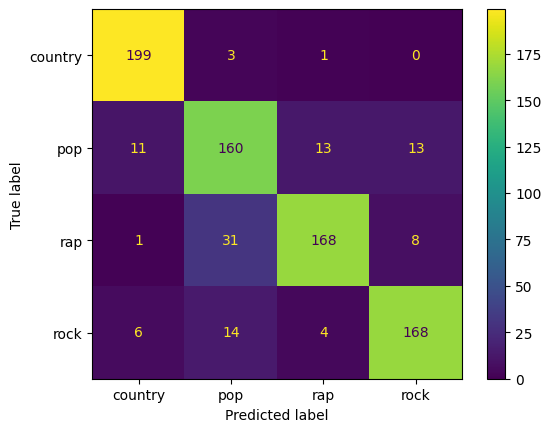

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: 'acum ajunge altul amar animal armă atinge avea cazi ce ciob cu cum cuvânt da de din doi dor durea el eu face față fi frumos gheață gol iar ieri inime inimă iubire jos la lovi mai masă meu nu oricât palmă pe piesei pre pregăti privire punte putea refren rău război sta strofa sub suflet să talpă tare tot trăi tu ucide uit un unul urmă veni vers vorbă în îneca înger întreba și ține'

In [ ]:
#THE OG
# from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# from sklearn.metrics import log_loss

# class RomanianMeanEmbeddingVectorizer:
#     def __init__(self, word2vec):
#         self.word2vec = word2vec
#         self.dim = len(next(iter(word2vec.values())))

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return np.array([
#             np.mean([self.word2vec[w] for w in words.split() if w in self.word2vec]
#                     or [np.zeros(self.dim)], axis=0)
#             for words in X
#         ])
#     def get_params(self, deep=True):
#          return {"word2vec": self.word2vec}



# X = df_balanced[['lyrics', 'repetition_score', 'word_count_normalized']]
# y = df_balanced['tag']

# text_tfidf = TfidfVectorizer(analyzer='word', max_features=5000)
# num_transformer = MinMaxScaler()

# preprocessor_tfidf = ColumnTransformer(
#     transformers=[
#         ('text', text_tfidf, 'lyrics'),
#         ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
#     ]
# )

# preprocessor_fasttext = ColumnTransformer(
#     transformers=[
#         ('text', RomanianMeanEmbeddingVectorizer(fasttext_ro), 'lyrics'),
#         ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
#     ]
# )

# # num_transformer = StandardScaler()

# # preprocessor_tfidf = ColumnTransformer(
# #     transformers=[
# #         ('text', text_tfidf, 'lyrics'),
# #         ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
# #     ]
# # )

# # preprocessor_fasttext = ColumnTransformer(
# #     transformers=[
# #         ('text', RomanianMeanEmbeddingVectorizer(fasttext_ro), 'lyrics'),
# #         ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
# #     ]
# # )

# pipelines = {
#     'nb_tfidf': Pipeline([
#         ('preprocess', preprocessor_tfidf),
#         ('clf', MultinomialNB())
#     ]),
#     'svm_tfidf': Pipeline([
#         ('preprocess', preprocessor_tfidf),
#         ('clf', SVC(kernel='linear'))
#     ]),
#     'ft_mean': Pipeline([
#         ('preprocess', preprocessor_fasttext),
#         ('clf', ExtraTreesClassifier(n_estimators=200))
#     ]),
#     'ft_tfidf': Pipeline([
#         ('preprocess', preprocessor_fasttext),
#         ('clf', ExtraTreesClassifier(n_estimators=200))
#     ]),
#     'svm_ovr_tfidf': Pipeline([
#         ('preprocess', preprocessor_tfidf),
#         ('clf', OneVsRestClassifier(SVC(kernel='linear')))
#     ]),
#     'logreg_ovr_tfidf': Pipeline([
#         ('preprocess', preprocessor_tfidf),
#         ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000)))
#     ]),
#     'svm_ovr_fasttext': Pipeline([
#         ('preprocess', preprocessor_fasttext),
#         ('clf', OneVsRestClassifier(SVC(kernel='linear')))
#     ]),
#     'logreg_ovr_fasttext': Pipeline([
#         ('preprocess', preprocessor_fasttext),
#         ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000)))
#     ])
# }

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# results = []
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# for name, pipeline in pipelines.items():
#     # score = cross_val_score(pipeline, X, y, cv=cv).mean()
#     # results.append((name, score))
#     score = cross_val_score(pipeline, X_train, y_train, cv=cv).mean()
#     results.append((name, score))

#     # pipeline.fit(X, y)
#     pipeline.fit(X_train, y_train)
#     # y_pred_prob = pipeline.predict_proba(X_test)
#     # cross_entropy = log_loss(y_test, y_pred_prob)
#     # print(f"Cross-Entropy: {cross_entropy:.4f}")

#     y_pred = pipeline.predict(X_test)
#     if hasattr(pipeline.named_steps['clf'], 'decision_function'):
#       decision_scores = pipeline.named_steps['clf'].decision_function(X_test)
#       print(f"Example Decision Scores (for SVM): {decision_scores[:5]}")


#     # Get class labels for OneVsRestClassifier
#     if isinstance(pipeline.named_steps['clf'], OneVsRestClassifier):
#         print(f"Class order for {name}: {pipeline.named_steps['clf'].classes_}")




#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred, average='weighted')
#     recall = recall_score(y_test, y_pred, average='weighted')
#     f1 = f1_score(y_test, y_pred, average='weighted')

#     print(f"\nModel: {name}")
#     print(f"Cross-validation Score: {score:.4f}")
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1-Score: {f1:.4f}")
#     print("Classification Report:\n", classification_report(y_test, y_pred))
#     #print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

#     from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#     import matplotlib.pyplot as plt

#     cm = confusion_matrix(y_test, y_pred)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
#     disp.plot()
#     plt.show()






# print(tabulate(results, headers=['Model', 'Score'], floatfmt=".4f"))


Model: nb_tfidf
Cross-validation Score: 0.8534
Accuracy: 0.8688
Precision: 0.8703
Recall: 0.8688
F1-Score: 0.8684
Classification Report:
               precision    recall  f1-score   support

     country       0.92      0.98      0.95       203
         pop       0.77      0.81      0.79       197
         rap       0.90      0.81      0.85       208
        rock       0.89      0.88      0.88       192

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.87      0.87      0.87       800



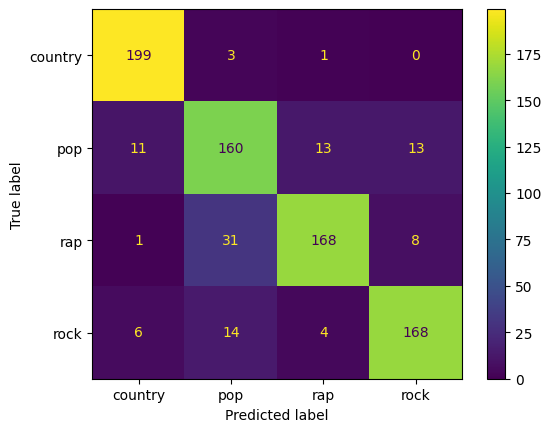

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: 'acum ajunge altul amar animal armă atinge avea cazi ce ciob cu cum cuvânt da de din doi dor durea el eu face față fi frumos gheață gol iar ieri inime inimă iubire jos la lovi mai masă meu nu oricât palmă pe piesei pre pregăti privire punte putea refren rău război sta strofa sub suflet să talpă tare tot trăi tu ucide uit un unul urmă veni vers vorbă în îneca înger întreba și ține'

In [ ]:
# THE CHAT GPT
# from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# from sklearn.metrics import log_loss

# class RomanianMeanEmbeddingVectorizer:
#     def __init__(self, word2vec):
#         self.word2vec = word2vec
#         self.dim = len(next(iter(word2vec.values())))

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return np.array([
#             np.mean([self.word2vec[w] for w in words.split() if w in self.word2vec]
#                     or [np.zeros(self.dim)], axis=0)
#             for words in X
#         ])
#     def get_params(self, deep=True):
#          return {"word2vec": self.word2vec}



# X = df_balanced[['lyrics', 'repetition_score', 'word_count_normalized']]
# y = df_balanced['tag']

# text_tfidf = TfidfVectorizer(analyzer='word', max_features=5000)
# num_transformer = MinMaxScaler()

# preprocessor_tfidf = ColumnTransformer(
#     transformers=[
#         ('text', text_tfidf, 'lyrics'),
#         ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
#     ]
# )

# preprocessor_fasttext = ColumnTransformer(
#     transformers=[
#         ('text', RomanianMeanEmbeddingVectorizer(fasttext_ro), 'lyrics'),
#         ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
#     ]
# )

# # num_transformer = StandardScaler()

# # preprocessor_tfidf = ColumnTransformer(
# #     transformers=[
# #         ('text', text_tfidf, 'lyrics'),
# #         ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
# #     ]
# # )

# # preprocessor_fasttext = ColumnTransformer(
# #     transformers=[
# #         ('text', RomanianMeanEmbeddingVectorizer(fasttext_ro), 'lyrics'),
# #         ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
# #     ]
# # )

# pipelines = {
#     'nb_tfidf': Pipeline([
#         ('preprocess', preprocessor_tfidf),
#         ('clf', MultinomialNB())
#     ]),
#     'svm_tfidf': Pipeline([
#         ('preprocess', preprocessor_tfidf),
#         ('clf', SVC(kernel='linear'))
#     ]),
#     'ft_mean': Pipeline([
#         ('preprocess', preprocessor_fasttext),
#         ('clf', ExtraTreesClassifier(n_estimators=200))
#     ]),
#     'ft_tfidf': Pipeline([
#         ('preprocess', preprocessor_fasttext),
#         ('clf', ExtraTreesClassifier(n_estimators=200))
#     ]),
#     'svm_ovr_tfidf': Pipeline([
#         ('preprocess', preprocessor_tfidf),
#         ('clf', OneVsRestClassifier(SVC(kernel='linear')))
#     ]),
#     'logreg_ovr_tfidf': Pipeline([
#         ('preprocess', preprocessor_tfidf),
#         ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000)))
#     ]),
#     'svm_ovr_fasttext': Pipeline([
#         ('preprocess', preprocessor_fasttext),
#         ('clf', OneVsRestClassifier(SVC(kernel='linear')))
#     ]),
#     'logreg_ovr_fasttext': Pipeline([
#         ('preprocess', preprocessor_fasttext),
#         ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000)))
#     ]),
#     'extratrees_fasttext': Pipeline([
#         ('preprocess', preprocessor_fasttext),
#         ('clf', ExtraTreesClassifier(n_estimators=300, max_depth=20, random_state=42))
#     ]),
#     'extratrees_tfidf': Pipeline([
#         ('preprocess', preprocessor_tfidf),
#         ('clf', ExtraTreesClassifier(n_estimators=300, max_depth=20, random_state=42))
#     ]),
# }

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# results = []
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# for name, pipeline in pipelines.items():
#     # score = cross_val_score(pipeline, X, y, cv=cv).mean()
#     # results.append((name, score))
#     score = cross_val_score(pipeline, X_train, y_train, cv=cv).mean()
#     results.append((name, score))

#     # pipeline.fit(X, y)
#     pipeline.fit(X_train, y_train)
#     # y_pred_prob = pipeline.predict_proba(X_test)
#     # cross_entropy = log_loss(y_test, y_pred_prob)
#     # print(f"Cross-Entropy: {cross_entropy:.4f}")

#     y_pred = pipeline.predict(X_test)
#     if hasattr(pipeline.named_steps['clf'], 'decision_function'):
#       decision_scores = pipeline.named_steps['clf'].decision_function(X_test)
#       print(f"Example Decision Scores (for SVM): {decision_scores[:5]}")


#     # Get class labels for OneVsRestClassifier
#     if isinstance(pipeline.named_steps['clf'], OneVsRestClassifier):
#         print(f"Class order for {name}: {pipeline.named_steps['clf'].classes_}")




#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred, average='weighted')
#     recall = recall_score(y_test, y_pred, average='weighted')
#     f1 = f1_score(y_test, y_pred, average='weighted')

#     print(f"\nModel: {name}")
#     print(f"Cross-validation Score: {score:.4f}")
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1-Score: {f1:.4f}")
#     print("Classification Report:\n", classification_report(y_test, y_pred))
#     #print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

#     from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#     import matplotlib.pyplot as plt

#     cm = confusion_matrix(y_test, y_pred)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
#     disp.plot()
#     plt.show()






# print(tabulate(results, headers=['Model', 'Score'], floatfmt=".4f"))


Processing model: nb_tfidf
Example Probabilities (for nb_tfidf, using transformed data): [[1.15649489e-02 6.22353881e-01 2.86610394e-02 3.37420131e-01]
 [4.85769874e-03 3.08187658e-02 1.02155065e-02 9.54108029e-01]
 [8.18158306e-02 7.17136846e-01 2.28269117e-02 1.78220412e-01]
 [7.14995996e-02 3.65998140e-01 1.33157791e-01 4.29344469e-01]
 [9.87002803e-01 2.89673231e-03 4.97914228e-04 9.60255026e-03]]
Class order for nb_tfidf: ['country' 'pop' 'rap' 'rock']

Model: nb_tfidf
Cross-validation Score: 0.8534
Accuracy: 0.8688
Precision: 0.8703
Recall: 0.8688
F1-Score: 0.8684
Classification Report:
               precision    recall  f1-score   support

     country       0.92      0.98      0.95       203
         pop       0.77      0.81      0.79       197
         rap       0.90      0.81      0.85       208
        rock       0.89      0.88      0.88       192

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       

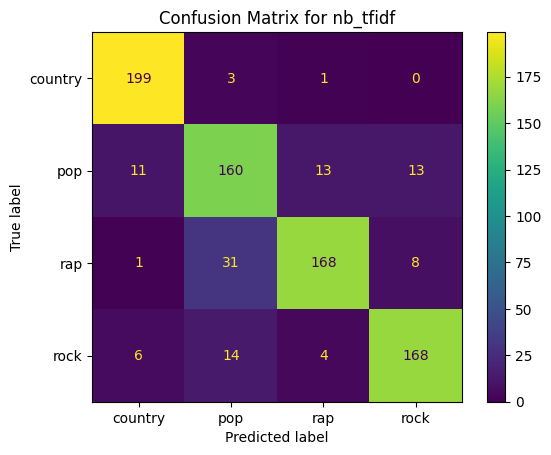

Processing model: svm_tfidf
Example Decision Scores (for svm_tfidf, using manually transformed data): [[-0.24942813  3.26867168  0.76398966  2.18470424]
 [-0.22554442  1.88266748  0.80666013  3.26688901]
 [ 0.7886545   3.27218737 -0.24709083  2.04250367]
 [ 0.79077792  2.1990652  -0.24204587  3.24685739]
 [ 3.25653244  0.84636414 -0.25384445  2.13819627]]
Class order for svm_tfidf: ['country' 'pop' 'rap' 'rock']

Model: svm_tfidf
Cross-validation Score: 0.8819
Accuracy: 0.8962
Precision: 0.8975
Recall: 0.8962
F1-Score: 0.8966
Classification Report:
               precision    recall  f1-score   support

     country       0.98      0.97      0.97       203
         pop       0.80      0.82      0.81       197
         rap       0.92      0.88      0.90       208
        rock       0.88      0.92      0.90       192

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



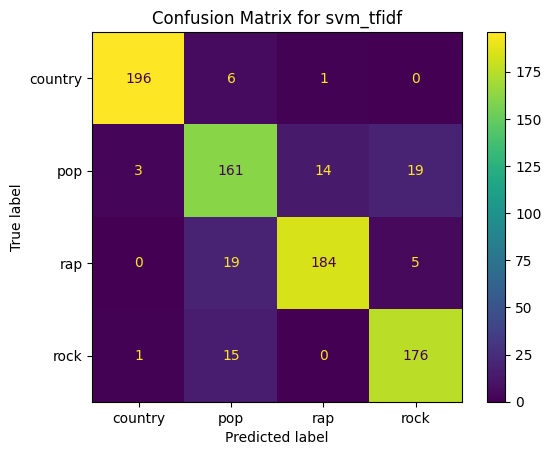

Processing model: ft_mean
Example Probabilities (for ft_mean, using transformed data): [[0.145 0.445 0.08  0.33 ]
 [0.06  0.08  0.12  0.74 ]
 [0.26  0.4   0.06  0.28 ]
 [0.235 0.195 0.25  0.32 ]
 [1.    0.    0.    0.   ]]
Class order for ft_mean: ['country' 'pop' 'rap' 'rock']

Model: ft_mean
Cross-validation Score: 0.8209
Accuracy: 0.8588
Precision: 0.8585
Recall: 0.8588
F1-Score: 0.8580
Classification Report:
               precision    recall  f1-score   support

     country       0.90      0.98      0.94       203
         pop       0.78      0.79      0.78       197
         rap       0.88      0.83      0.85       208
        rock       0.87      0.83      0.85       192

    accuracy                           0.86       800
   macro avg       0.86      0.86      0.86       800
weighted avg       0.86      0.86      0.86       800



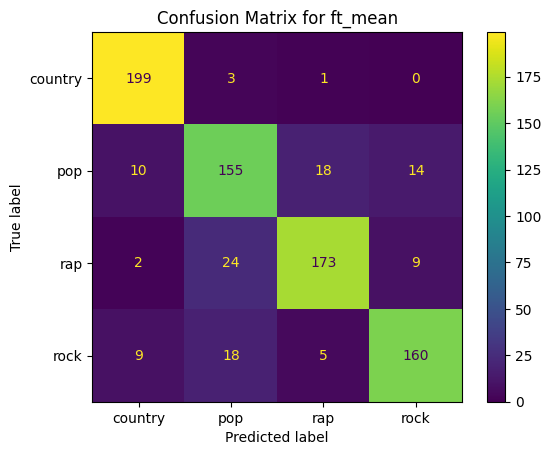

Processing model: ft_tfidf
Example Probabilities (for ft_tfidf, using transformed data): [[0.145 0.445 0.08  0.33 ]
 [0.06  0.08  0.12  0.74 ]
 [0.26  0.4   0.06  0.28 ]
 [0.235 0.195 0.25  0.32 ]
 [1.    0.    0.    0.   ]]
Class order for ft_tfidf: ['country' 'pop' 'rap' 'rock']

Model: ft_tfidf
Cross-validation Score: 0.8209
Accuracy: 0.8588
Precision: 0.8585
Recall: 0.8588
F1-Score: 0.8580
Classification Report:
               precision    recall  f1-score   support

     country       0.90      0.98      0.94       203
         pop       0.78      0.79      0.78       197
         rap       0.88      0.83      0.85       208
        rock       0.87      0.83      0.85       192

    accuracy                           0.86       800
   macro avg       0.86      0.86      0.86       800
weighted avg       0.86      0.86      0.86       800



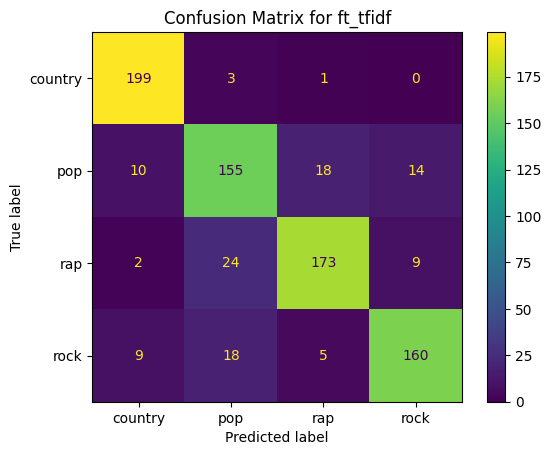

Processing model: svm_ovr_tfidf
Example Decision Scores (for svm_ovr_tfidf, using manually transformed data): [[-1.50954718  1.35107363 -2.11537559 -0.74269697]
 [-1.15704836 -1.42914736 -1.44502618  1.08770449]
 [-1.15429026  1.40730347 -1.99204765 -1.65192385]
 [-1.02948948 -0.47098032 -1.90354304  0.19476365]
 [ 0.98176316 -1.97444214 -1.52206398 -0.99619031]]
Class order for svm_ovr_tfidf: ['country' 'pop' 'rap' 'rock']

Model: svm_ovr_tfidf
Cross-validation Score: 0.8844
Accuracy: 0.8962
Precision: 0.8951
Recall: 0.8962
F1-Score: 0.8953
Classification Report:
               precision    recall  f1-score   support

     country       0.97      0.98      0.98       203
         pop       0.83      0.77      0.80       197
         rap       0.89      0.91      0.90       208
        rock       0.89      0.92      0.90       192

    accuracy                           0.90       800
   macro avg       0.89      0.90      0.89       800
weighted avg       0.90      0.90      0.90     

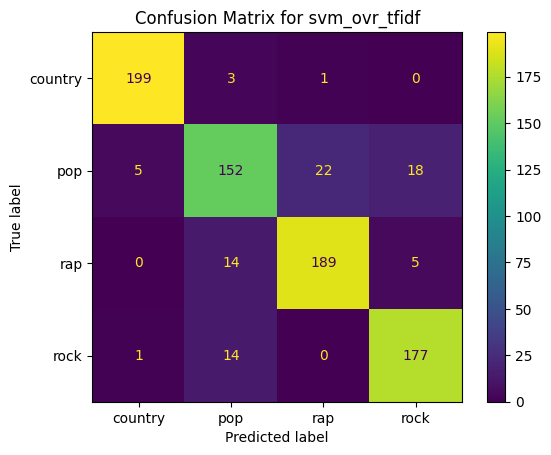

Processing model: logreg_ovr_tfidf
Example Decision Scores (for logreg_ovr_tfidf, using manually transformed data): [[-3.38803228  1.31097764 -3.10372483 -1.82252406]
 [-3.06507244 -2.54823764 -2.40211762  1.31083946]
 [-2.25842386  1.50010529 -3.95460822 -1.64379524]
 [-2.09808206 -0.77562861 -2.99383893 -0.60892221]
 [ 1.38559535 -2.95143619 -3.746129   -1.58977545]]
Class order for logreg_ovr_tfidf: ['country' 'pop' 'rap' 'rock']

Model: logreg_ovr_tfidf
Cross-validation Score: 0.8609
Accuracy: 0.8812
Precision: 0.8813
Recall: 0.8812
F1-Score: 0.8802
Classification Report:
               precision    recall  f1-score   support

     country       0.98      0.97      0.97       203
         pop       0.82      0.74      0.78       197
         rap       0.90      0.91      0.91       208
        rock       0.82      0.91      0.86       192

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88   

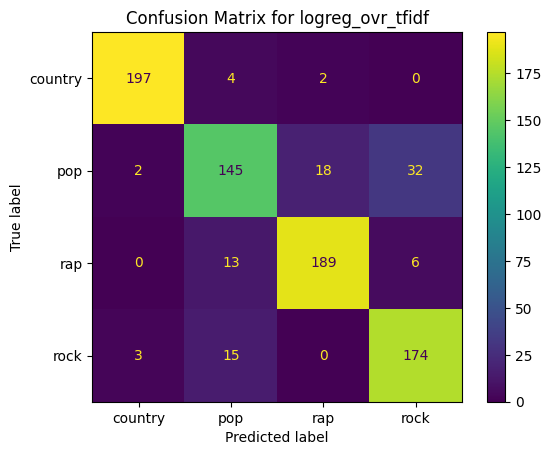

Processing model: svm_ovr_fasttext
Example Decision Scores (for svm_ovr_fasttext, using manually transformed data): [[-1.11944454 -0.04842163 -1.54313037 -1.23365778]
 [-1.10926088 -1.3624925  -1.20096481  0.12742824]
 [-0.44082002 -0.31715061 -2.36899865 -0.80580037]
 [-0.54000208 -0.85811766 -1.50102675 -0.95530256]
 [ 0.84092354 -1.56130941 -2.0741802  -0.88119677]]
Class order for svm_ovr_fasttext: ['country' 'pop' 'rap' 'rock']

Model: svm_ovr_fasttext
Cross-validation Score: 0.7894
Accuracy: 0.8313
Precision: 0.8279
Recall: 0.8313
F1-Score: 0.8275
Classification Report:
               precision    recall  f1-score   support

     country       0.89      0.98      0.93       203
         pop       0.79      0.67      0.72       197
         rap       0.83      0.90      0.86       208
        rock       0.80      0.77      0.79       192

    accuracy                           0.83       800
   macro avg       0.83      0.83      0.83       800
weighted avg       0.83      0.83   

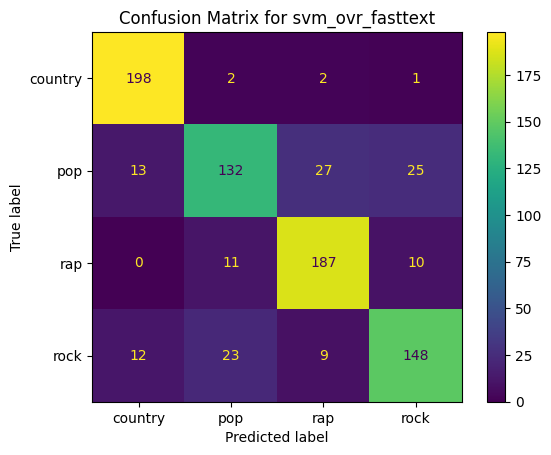

Processing model: logreg_ovr_fasttext
Example Decision Scores (for logreg_ovr_fasttext, using manually transformed data): [[-1.62446127 -0.14945312 -2.21341721 -1.9952203 ]
 [-1.76757549 -1.68518415 -1.94218992 -0.08945018]
 [-0.37222718 -0.62132165 -3.55783603 -1.07705857]
 [-0.95766398 -0.80175303 -2.34237202 -1.69196266]
 [ 0.35704826 -2.06110533 -3.10850861 -0.73861588]]
Class order for logreg_ovr_fasttext: ['country' 'pop' 'rap' 'rock']

Model: logreg_ovr_fasttext
Cross-validation Score: 0.7506
Accuracy: 0.7863
Precision: 0.7859
Recall: 0.7863
F1-Score: 0.7859
Classification Report:
               precision    recall  f1-score   support

     country       0.88      0.89      0.88       203
         pop       0.72      0.69      0.70       197
         rap       0.82      0.83      0.82       208
        rock       0.71      0.74      0.73       192

    accuracy                           0.79       800
   macro avg       0.78      0.78      0.78       800
weighted avg       0.79 

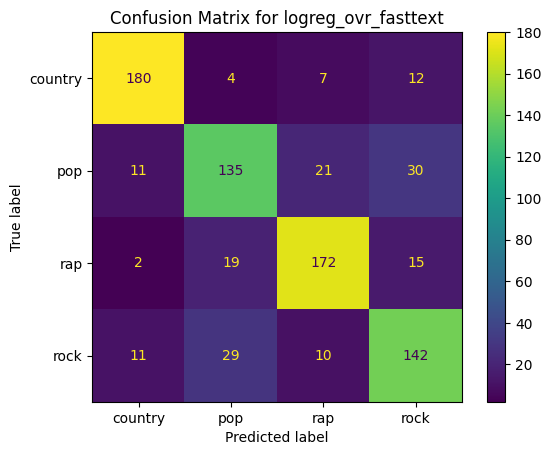

Processing model: extratrees_fasttext
Example Probabilities (for extratrees_fasttext, using transformed data): [[1.18529412e-01 4.71160763e-01 6.59215686e-02 3.44388257e-01]
 [6.01388889e-02 9.93771368e-02 1.33700321e-01 7.06783654e-01]
 [2.76262626e-01 3.96767677e-01 6.33333333e-02 2.63636364e-01]
 [2.37916667e-01 1.73304679e-01 2.20704310e-01 3.68074344e-01]
 [9.99326569e-01 2.49266887e-04 9.34755925e-05 3.30688414e-04]]
Class order for extratrees_fasttext: ['country' 'pop' 'rap' 'rock']

Model: extratrees_fasttext
Cross-validation Score: 0.8241
Accuracy: 0.8612
Precision: 0.8601
Recall: 0.8612
F1-Score: 0.8601
Classification Report:
               precision    recall  f1-score   support

     country       0.90      0.98      0.94       203
         pop       0.80      0.78      0.79       197
         rap       0.88      0.84      0.86       208
        rock       0.86      0.84      0.85       192

    accuracy                           0.86       800
   macro avg       0.86      

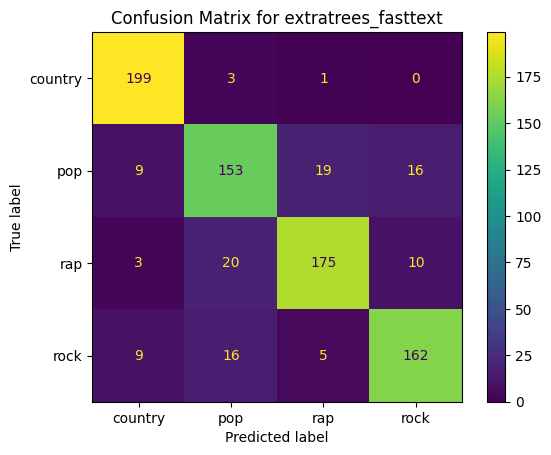

Processing model: extratrees_tfidf
Example Probabilities (for extratrees_tfidf, using transformed data): [[0.08166651 0.68042801 0.06795077 0.16995471]
 [0.06356236 0.11514907 0.16454053 0.65674805]
 [0.13128479 0.54596646 0.06771208 0.25503667]
 [0.08721827 0.22507718 0.29554182 0.39216273]
 [0.81778166 0.07692609 0.03176149 0.07353076]]
Class order for extratrees_tfidf: ['country' 'pop' 'rap' 'rock']

Model: extratrees_tfidf
Cross-validation Score: 0.8606
Accuracy: 0.8975
Precision: 0.8984
Recall: 0.8975
F1-Score: 0.8978
Classification Report:
               precision    recall  f1-score   support

     country       0.97      0.98      0.97       203
         pop       0.81      0.84      0.83       197
         rap       0.91      0.89      0.90       208
        rock       0.90      0.88      0.89       192

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



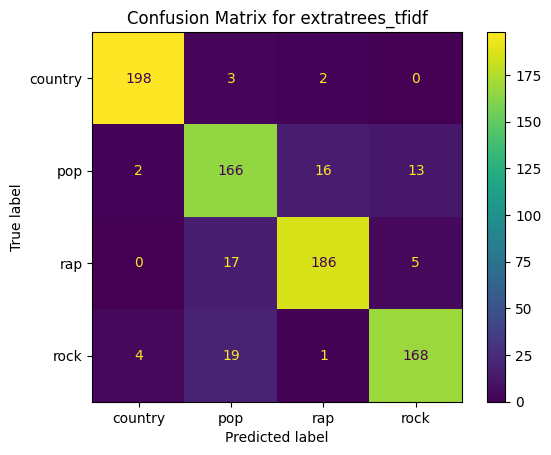


Summary of Cross-validation Scores:
Model                  Score
-------------------  -------
nb_tfidf              0.8534
svm_tfidf             0.8819
ft_mean               0.8209
ft_tfidf              0.8209
svm_ovr_tfidf         0.8844
logreg_ovr_tfidf      0.8609
svm_ovr_fasttext      0.7894
logreg_ovr_fasttext   0.7506
extratrees_fasttext   0.8241
extratrees_tfidf      0.8606


In [ ]:
#no errors
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin


class RomanianMeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values()))) if word2vec else 0

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.dim == 0 and self.word2vec:
             self.dim = len(next(iter(self.word2vec.values())))
        elif self.dim == 0:
             return np.empty((len(X), 0))

        return np.array([
            np.mean([self.word2vec[w] for w in words.split() if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    def get_params(self, deep=True):
        return {"word2vec": self.word2vec}


X = df_balanced[['lyrics', 'repetition_score', 'word_count_normalized']]
y = df_balanced['tag']

text_tfidf = TfidfVectorizer(analyzer='word', max_features=5000)
num_transformer = MinMaxScaler()

preprocessor_tfidf = ColumnTransformer(
    transformers=[
        ('text', text_tfidf, 'lyrics'),
        ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
    ]
)

preprocessor_fasttext = ColumnTransformer(
    transformers=[
        ('text', RomanianMeanEmbeddingVectorizer(fasttext_ro), 'lyrics'),
        ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
    ]
)

pipelines = {
    'nb_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', MultinomialNB())
    ]),
    'svm_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', SVC(kernel='linear', probability=True))
    ]),
    'ft_mean': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', ExtraTreesClassifier(n_estimators=200, random_state=42))
    ]),
    'ft_tfidf': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', ExtraTreesClassifier(n_estimators=200, random_state=42))
    ]),
    'svm_ovr_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', OneVsRestClassifier(SVC(kernel='linear', probability=True)))
    ]),
    'logreg_ovr_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42)))
    ]),
    'svm_ovr_fasttext': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', OneVsRestClassifier(SVC(kernel='linear', probability=True)))
    ]),
    'logreg_ovr_fasttext': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42)))
    ]),
    'extratrees_fasttext': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', ExtraTreesClassifier(n_estimators=300, max_depth=20, random_state=42))
    ]),
    'extratrees_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', ExtraTreesClassifier(n_estimators=300, max_depth=20, random_state=42))
    ]),
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

unique_classes = sorted(y.unique())

for name, pipeline in pipelines.items():
    print(f"Processing model: {name}")
    try:
        score = cross_val_score(pipeline, X_train, y_train, cv=cv, n_jobs=-1).mean()
        results.append((name, score))

        pipeline.fit(X_train, y_train)

        preprocessor = pipeline.named_steps['preprocess']
        clf = pipeline.named_steps['clf']
        X_test_transformed = preprocessor.transform(X_test)

        X_test_transformed_dense = X_test_transformed
        if hasattr(X_test_transformed, "toarray"):
             X_test_transformed_dense = X_test_transformed.toarray()


        decision_scores = None
        if hasattr(clf, 'decision_function'):
            try:
                decision_scores = clf.decision_function(X_test_transformed_dense)
                print(f"Example Decision Scores (for {name}, using manually transformed data): {decision_scores[:5]}")
            except ValueError as e:
                print(f"Could not compute decision_function for {name} using manually transformed data due to ValueError: {e}")
            except Exception as e:
                 print(f"Could not compute decision_function for {name} using manually transformed data due to an unexpected error: {e}")

        elif hasattr(clf, 'predict_proba'):
             try:

                 y_pred_prob = clf.predict_proba(X_test_transformed)
                 print(f"Example Probabilities (for {name}, using transformed data): {y_pred_prob[:5]}")
             except Exception as e:
                 print(f"Could not compute predict_proba for {name} using transformed data: {e}")


        model_classes = None
        if hasattr(clf, 'classes_'):
            model_classes = clf.classes_
        elif hasattr(clf, 'estimators_') and clf.estimators_:
            if hasattr(clf.estimators_[0], 'classes_'):
                 model_classes = clf.estimators_[0].classes_

        if model_classes is not None:
            print(f"Class order for {name}: {model_classes}")
        else:
             print(f"Could not determine class order for {name}")


        y_pred = pipeline.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        print(f"\nModel: {name}")
        print(f"Cross-validation Score: {score:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

        cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
        disp.plot()
        plt.title(f"Confusion Matrix for {name}")
        plt.show()

    except Exception as e:
        print(f"An error occurred during processing of pipeline {name}: {e}")
        results.append((name, 'Error'))


print("\nSummary of Cross-validation Scores:")
print(tabulate(results, headers=['Model', 'Score'], floatfmt=".4f"))

Processing model: nb_tfidf
Example Probabilities (for nb_tfidf, using transformed data): [[3.89939721e-03 8.86087005e-01 3.48480079e-02 7.51655897e-02]
 [3.68187571e-03 3.52451327e-03 1.13138393e-03 9.91662227e-01]
 [1.18360710e-02 9.11822885e-01 1.25854747e-02 6.37555695e-02]
 [1.25669230e-01 9.44990847e-03 7.93626292e-03 8.56944598e-01]
 [9.89032004e-01 3.00869973e-04 6.53084910e-05 1.06018179e-02]]
Class order for nb_tfidf: ['country' 'pop' 'rap' 'rock']

Model: nb_tfidf
Cross-validation Score: 0.8456
Accuracy: 0.8538
Precision: 0.8708
Recall: 0.8538
F1-Score: 0.8565
Classification Report:
               precision    recall  f1-score   support

     country       0.95      0.95      0.95       203
         pop       0.68      0.85      0.76       197
         rap       0.88      0.86      0.87       208
        rock       0.97      0.75      0.85       192

    accuracy                           0.85       800
   macro avg       0.87      0.85      0.86       800
weighted avg       

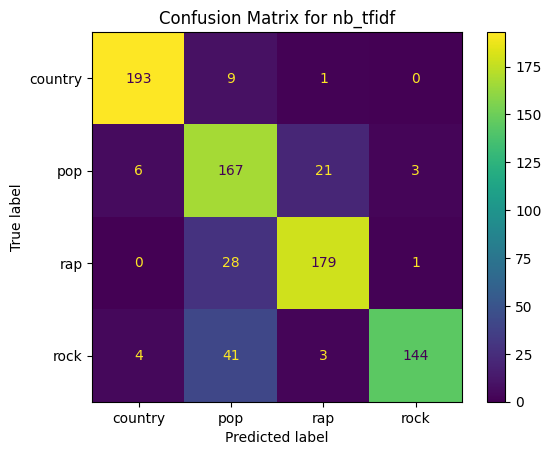

Processing model: svm_tfidf
Example Decision Scores (for svm_tfidf, using manually transformed data): [[-0.23804112  3.26534247  0.77698058  2.12719954]
 [-0.20490741  1.95886715  0.80183416  3.25401312]
 [ 0.77975721  3.26607481 -0.24518409  2.1453233 ]
 [ 0.8287704   2.13940843 -0.23735781  3.24585634]
 [ 3.25089078  0.83196088 -0.25184946  2.17184838]]
Class order for svm_tfidf: ['country' 'pop' 'rap' 'rock']

Model: svm_tfidf
Cross-validation Score: 0.8631
Accuracy: 0.8762
Precision: 0.8769
Recall: 0.8762
F1-Score: 0.8765
Classification Report:
               precision    recall  f1-score   support

     country       0.98      0.97      0.97       203
         pop       0.77      0.78      0.78       197
         rap       0.89      0.88      0.88       208
        rock       0.86      0.88      0.87       192

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88      0.88       800



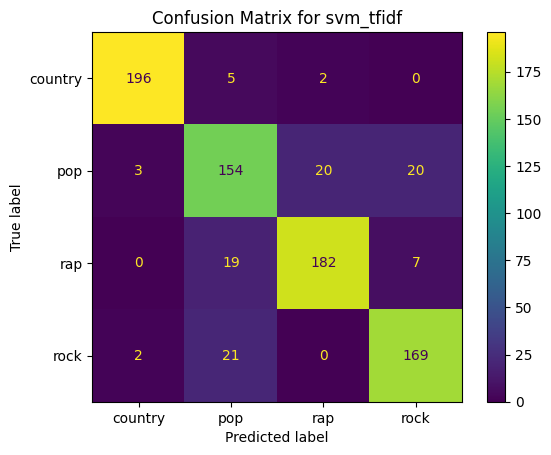

Processing model: ft_mean
Example Probabilities (for ft_mean, using transformed data): [[0.125 0.45  0.06  0.365]
 [0.045 0.135 0.12  0.7  ]
 [0.335 0.33  0.095 0.24 ]
 [0.19  0.18  0.215 0.415]
 [1.    0.    0.    0.   ]]
Class order for ft_mean: ['country' 'pop' 'rap' 'rock']

Model: ft_mean
Cross-validation Score: 0.8241
Accuracy: 0.8675
Precision: 0.8672
Recall: 0.8675
F1-Score: 0.8667
Classification Report:
               precision    recall  f1-score   support

     country       0.91      0.99      0.95       203
         pop       0.78      0.79      0.78       197
         rap       0.89      0.84      0.86       208
        rock       0.89      0.85      0.87       192

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.87      0.87      0.87       800



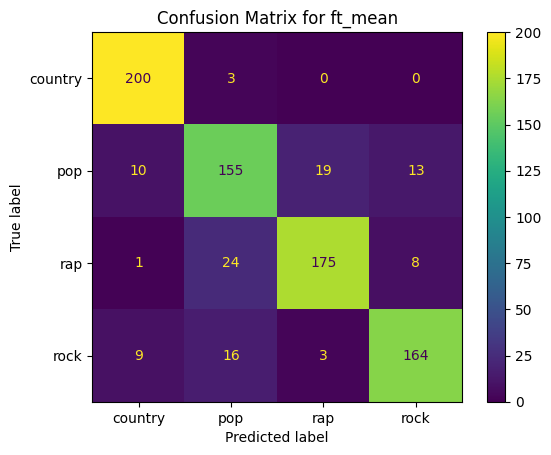

Processing model: ft_tfidf
Example Probabilities (for ft_tfidf, using transformed data): [[0.125 0.45  0.06  0.365]
 [0.045 0.135 0.12  0.7  ]
 [0.335 0.33  0.095 0.24 ]
 [0.19  0.18  0.215 0.415]
 [1.    0.    0.    0.   ]]
Class order for ft_tfidf: ['country' 'pop' 'rap' 'rock']

Model: ft_tfidf
Cross-validation Score: 0.8241
Accuracy: 0.8675
Precision: 0.8672
Recall: 0.8675
F1-Score: 0.8667
Classification Report:
               precision    recall  f1-score   support

     country       0.91      0.99      0.95       203
         pop       0.78      0.79      0.78       197
         rap       0.89      0.84      0.86       208
        rock       0.89      0.85      0.87       192

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.87      0.87      0.87       800



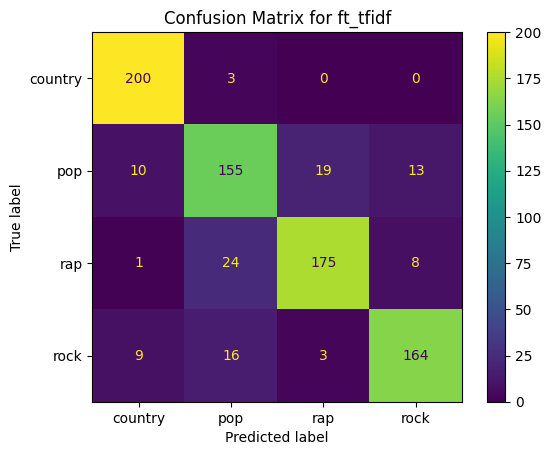

Processing model: svm_ovr_tfidf
Example Decision Scores (for svm_ovr_tfidf, using manually transformed data): [[-1.38851272  0.93778971 -1.93266865 -0.74477118]
 [-0.98855568 -1.33461391 -1.37930732  0.81137962]
 [-1.15815405  1.38725232 -1.75499987 -1.19404214]
 [-0.74540439 -0.91414476 -1.89227359  0.64788109]
 [ 0.98063228 -2.11812788 -1.57435714 -0.99330381]]
Class order for svm_ovr_tfidf: ['country' 'pop' 'rap' 'rock']

Model: svm_ovr_tfidf
Cross-validation Score: 0.8650
Accuracy: 0.8800
Precision: 0.8788
Recall: 0.8800
F1-Score: 0.8792
Classification Report:
               precision    recall  f1-score   support

     country       0.96      0.97      0.96       203
         pop       0.80      0.76      0.78       197
         rap       0.87      0.90      0.88       208
        rock       0.90      0.89      0.89       192

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88      0.88     

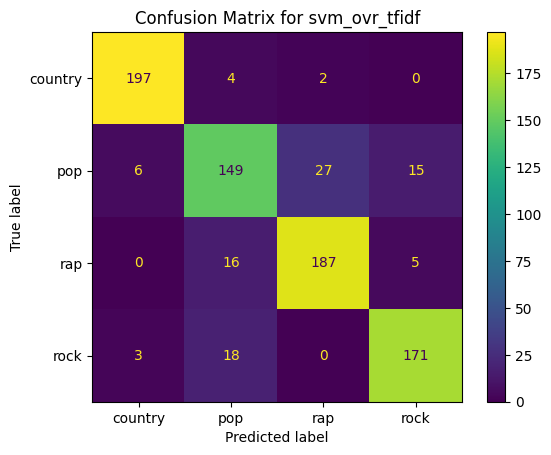

Processing model: logreg_ovr_tfidf
Example Decision Scores (for logreg_ovr_tfidf, using manually transformed data): [[-3.00227877  0.92620396 -2.7755369  -1.99200985]
 [-2.64050112 -2.92185034 -2.75480528  1.37500199]
 [-2.27036058  1.32591613 -3.86188027 -1.30890881]
 [-1.56655136 -2.25707358 -3.54438117  0.09428803]
 [ 1.40308274 -3.58927673 -3.91861031 -1.15347868]]
Class order for logreg_ovr_tfidf: ['country' 'pop' 'rap' 'rock']

Model: logreg_ovr_tfidf
Cross-validation Score: 0.8566
Accuracy: 0.8850
Precision: 0.8855
Recall: 0.8850
F1-Score: 0.8852
Classification Report:
               precision    recall  f1-score   support

     country       0.97      0.96      0.96       203
         pop       0.79      0.80      0.79       197
         rap       0.92      0.90      0.91       208
        rock       0.86      0.88      0.87       192

    accuracy                           0.89       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.89      0.89   

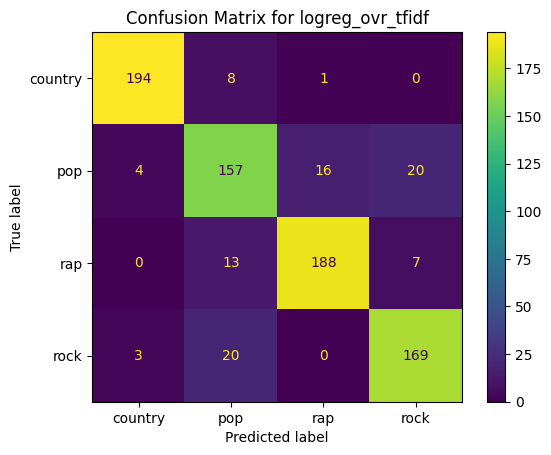

Processing model: svm_ovr_fasttext
Example Decision Scores (for svm_ovr_fasttext, using manually transformed data): [[-1.71299231  0.41954474 -2.24339356 -0.59665618]
 [-1.68062024 -1.66228143 -1.85985435  0.66779905]
 [-0.36743712  0.52531475 -3.1502543  -1.02150968]
 [-0.97037588 -1.0339572  -1.99889274 -0.40205983]
 [ 1.72028489 -2.27810248 -2.66037318 -1.20096871]]
Class order for svm_ovr_fasttext: ['country' 'pop' 'rap' 'rock']

Model: svm_ovr_fasttext
Cross-validation Score: 0.8303
Accuracy: 0.8475
Precision: 0.8448
Recall: 0.8475
F1-Score: 0.8454
Classification Report:
               precision    recall  f1-score   support

     country       0.91      0.97      0.94       203
         pop       0.78      0.71      0.74       197
         rap       0.85      0.87      0.86       208
        rock       0.83      0.84      0.84       192

    accuracy                           0.85       800
   macro avg       0.84      0.85      0.84       800
weighted avg       0.84      0.85   

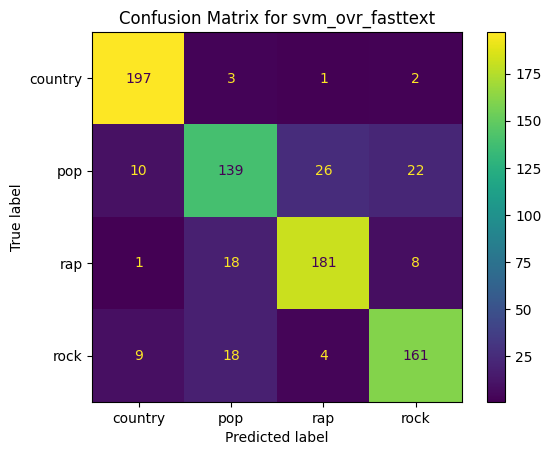

Processing model: logreg_ovr_fasttext
Example Decision Scores (for logreg_ovr_fasttext, using manually transformed data): [[-2.87618455  0.25898027 -3.50606116 -1.00295794]
 [-2.98967377 -2.1177874  -2.63911838  0.65386869]
 [-0.78005524  0.11712134 -5.14651583 -1.84744609]
 [-1.82574652 -1.4450471  -2.87688641 -1.16418621]
 [ 2.13260429 -3.13844442 -4.67268785 -1.82908684]]
Class order for logreg_ovr_fasttext: ['country' 'pop' 'rap' 'rock']

Model: logreg_ovr_fasttext
Cross-validation Score: 0.8169
Accuracy: 0.8438
Precision: 0.8415
Recall: 0.8438
F1-Score: 0.8421
Classification Report:
               precision    recall  f1-score   support

     country       0.90      0.97      0.93       203
         pop       0.76      0.73      0.74       197
         rap       0.87      0.87      0.87       208
        rock       0.83      0.80      0.81       192

    accuracy                           0.84       800
   macro avg       0.84      0.84      0.84       800
weighted avg       0.84 

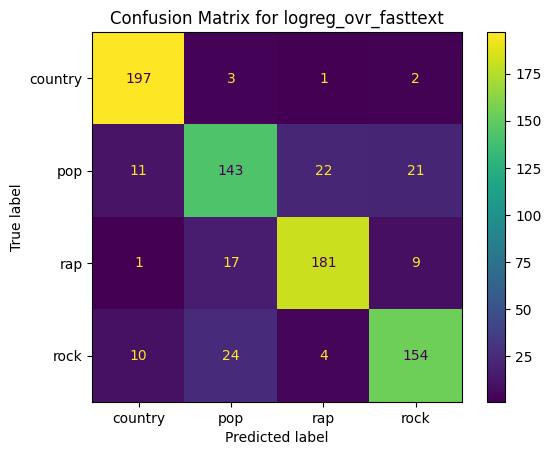

Processing model: extratrees_fasttext
Example Probabilities (for extratrees_fasttext, using transformed data): [[1.25929182e-01 4.09322344e-01 7.66666667e-02 3.88081807e-01]
 [4.39265700e-02 1.50811594e-01 1.25048309e-01 6.80213527e-01]
 [3.30000000e-01 3.62500000e-01 7.67592593e-02 2.30740741e-01]
 [2.29722222e-01 1.88819444e-01 2.00416667e-01 3.81041667e-01]
 [9.94365857e-01 4.92034032e-03 1.11051646e-04 6.02750717e-04]]
Class order for extratrees_fasttext: ['country' 'pop' 'rap' 'rock']

Model: extratrees_fasttext
Cross-validation Score: 0.8234
Accuracy: 0.8675
Precision: 0.8666
Recall: 0.8675
F1-Score: 0.8666
Classification Report:
               precision    recall  f1-score   support

     country       0.91      0.98      0.95       203
         pop       0.80      0.79      0.79       197
         rap       0.88      0.85      0.86       208
        rock       0.87      0.85      0.86       192

    accuracy                           0.87       800
   macro avg       0.87      

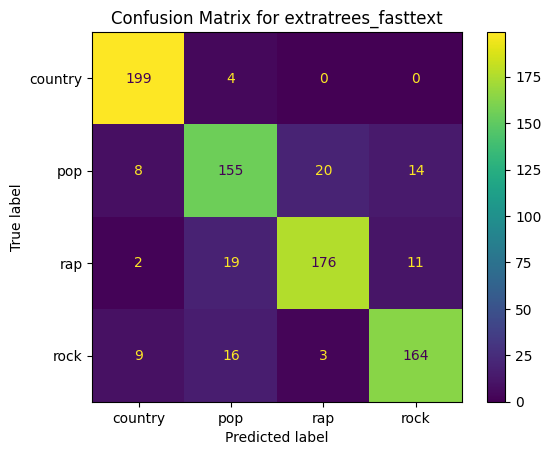

Processing model: extratrees_tfidf
Example Probabilities (for extratrees_tfidf, using transformed data): [[0.07278112 0.58609495 0.15104428 0.19007965]
 [0.10270202 0.09707445 0.08867718 0.71154635]
 [0.09851692 0.55511651 0.08356524 0.26280132]
 [0.15641924 0.12369454 0.16050709 0.55937913]
 [0.80740613 0.06554189 0.03042438 0.0966276 ]]
Class order for extratrees_tfidf: ['country' 'pop' 'rap' 'rock']

Model: extratrees_tfidf
Cross-validation Score: 0.8522
Accuracy: 0.8662
Precision: 0.8715
Recall: 0.8662
F1-Score: 0.8680
Classification Report:
               precision    recall  f1-score   support

     country       0.98      0.92      0.95       203
         pop       0.74      0.83      0.78       197
         rap       0.90      0.88      0.89       208
        rock       0.86      0.84      0.85       192

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.87      0.87      0.87       800



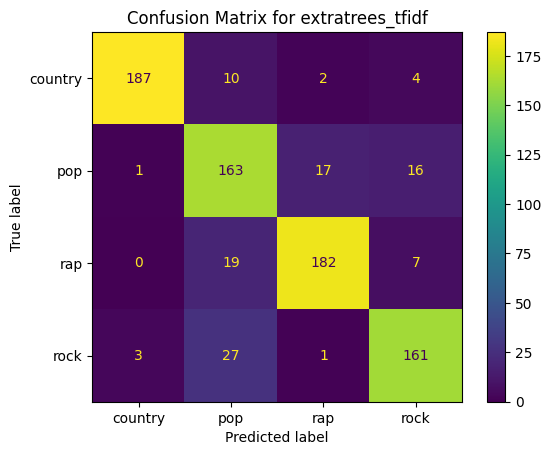


Summary of Cross-validation Scores:
Model                  Score
-------------------  -------
nb_tfidf              0.8456
svm_tfidf             0.8631
ft_mean               0.8241
ft_tfidf              0.8241
svm_ovr_tfidf         0.8650
logreg_ovr_tfidf      0.8566
svm_ovr_fasttext      0.8303
logreg_ovr_fasttext   0.8169
extratrees_fasttext   0.8234
extratrees_tfidf      0.8522


In [ ]:
#EXEPRIMENT: folosesc si ngrams la tfidf, in loc de doar cuvinte unice
# la fastText, in loc sa fac doar mean, fac TF-IDF weighted averages
#CONCLUZII: fasttextu ii mai bun, tf-idf u era mai bun fara n grams
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.base import BaseEstimator, TransformerMixin

class TFIDFWeightedEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values()))) if word2vec else 0

    def fit(self, X, y=None):
        from sklearn.feature_extraction.text import TfidfVectorizer
        self.tfidf = TfidfVectorizer()
        self.tfidf.fit(X)
        self.idf_dict = dict(zip(self.tfidf.get_feature_names_out(), self.tfidf.idf_))
        return self

    def transform(self, X):
        output = []
        for doc in X:
            words = doc.split()
            vecs = []
            weights = []
            for word in words:
                if word in self.word2vec:
                    vec = self.word2vec[word]
                    weight = self.idf_dict.get(word, 1.0)
                    vecs.append(vec * weight)
                    weights.append(weight)
            if vecs:
                vecs = np.array(vecs)
                output.append(np.mean(vecs, axis=0))
            else:
                output.append(np.zeros(self.dim))
        return np.array(output)

    def get_params(self, deep=True):
        return {"word2vec": self.word2vec}



X = df_balanced[['lyrics', 'repetition_score', 'word_count_normalized']]
y = df_balanced['tag']

text_tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), max_features=5000)
num_transformer = MinMaxScaler()

preprocessor_tfidf = ColumnTransformer(
    transformers=[
        ('text', text_tfidf, 'lyrics'),
        ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
    ]
)

preprocessor_fasttext = ColumnTransformer(
    transformers=[
        ('text', TFIDFWeightedEmbeddingVectorizer(fasttext_ro), 'lyrics'),
        ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
    ]
)


pipelines = {
    'nb_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', MultinomialNB())
    ]),
    'svm_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', SVC(kernel='linear', probability=True))
    ]),
    'ft_mean': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', ExtraTreesClassifier(n_estimators=200, random_state=42))
    ]),
    'ft_tfidf': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', ExtraTreesClassifier(n_estimators=200, random_state=42))
    ]),
    'svm_ovr_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', OneVsRestClassifier(SVC(kernel='linear', probability=True)))
    ]),
    'logreg_ovr_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42)))
    ]),
    'svm_ovr_fasttext': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', OneVsRestClassifier(SVC(kernel='linear', probability=True)))
    ]),
    'logreg_ovr_fasttext': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42)))
    ]),
    'extratrees_fasttext': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', ExtraTreesClassifier(n_estimators=300, max_depth=20, random_state=42))
    ]),
    'extratrees_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', ExtraTreesClassifier(n_estimators=300, max_depth=20, random_state=42))
    ]),
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

unique_classes = sorted(y.unique())

for name, pipeline in pipelines.items():
    print(f"Processing model: {name}")
    try:
        score = cross_val_score(pipeline, X_train, y_train, cv=cv, n_jobs=-1).mean()
        results.append((name, score))

        pipeline.fit(X_train, y_train)

        preprocessor = pipeline.named_steps['preprocess']
        clf = pipeline.named_steps['clf']


        X_test_transformed = preprocessor.transform(X_test)

        X_test_transformed_dense = X_test_transformed
        if hasattr(X_test_transformed, "toarray"):
             X_test_transformed_dense = X_test_transformed.toarray()


        decision_scores = None
        if hasattr(clf, 'decision_function'):
            try:
                decision_scores = clf.decision_function(X_test_transformed_dense)
                print(f"Example Decision Scores (for {name}, using manually transformed data): {decision_scores[:5]}")
            except ValueError as e:
                print(f"Could not compute decision_function for {name} using manually transformed data due to ValueError: {e}")
            except Exception as e:
                 print(f"Could not compute decision_function for {name} using manually transformed data due to an unexpected error: {e}")

        elif hasattr(clf, 'predict_proba'):
             try:
                 y_pred_prob = clf.predict_proba(X_test_transformed)
                 print(f"Example Probabilities (for {name}, using transformed data): {y_pred_prob[:5]}")
             except Exception as e:
                 print(f"Could not compute predict_proba for {name} using transformed data: {e}")


        model_classes = None
        if hasattr(clf, 'classes_'):
            model_classes = clf.classes_
        elif hasattr(clf, 'estimators_') and clf.estimators_:

            if hasattr(clf.estimators_[0], 'classes_'):
                 model_classes = clf.estimators_[0].classes_

        if model_classes is not None:
            print(f"Class order for {name}: {model_classes}")
        else:
             print(f"Could not determine class order for {name}")


        y_pred = pipeline.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        print(f"\nModel: {name}")
        print(f"Cross-validation Score: {score:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

        cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
        disp.plot()
        plt.title(f"Confusion Matrix for {name}")
        plt.show()

    except Exception as e:
        print(f"An error occurred during processing of pipeline {name}: {e}")
        results.append((name, 'Error'))


print("\nSummary of Cross-validation Scores:")
print(tabulate(results, headers=['Model', 'Score'], floatfmt=".4f"))


--- Analyzing Top N-grams/Words per Genre (Mutual Information) ---


Datele de ieșire de afișat au fost trunchiate la ultimele 5000 linii.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values


Top 10 features for country (vs. Others):
măi      0.303132
lume     0.254802
vedea    0.226906
vrea     0.214447
veni     0.212462
duce     0.193122
dor      0.181912
spune    0.176321
sta      0.175534
om       0.174718
dtype: float64


Datele de ieșire de afișat au fost trunchiate la ultimele 5000 linii.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values


Top 10 features for pop (vs. Others):
vrea     0.290737
spune    0.220369
vedea    0.211141
lume     0.177339
sta      0.168439
ști      0.162544
veni     0.153105
simți    0.148520
inimă    0.145945
crede    0.138647
dtype: float64


Datele de ieșire de afișat au fost trunchiate la ultimele 5000 linii.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values


Top 10 features for rap (vs. Others):
vrea     0.303586
vedea    0.301319
sta      0.234315
lume     0.208412
veni     0.201522
ban      0.198911
spune    0.197058
ști      0.186934
pune     0.174495
lua      0.169005
dtype: float64


Datele de ieșire de afișat au fost trunchiate la ultimele 5000 linii.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values


Top 10 features for rock (vs. Others):
vrea     0.248425
lume     0.229036
vedea    0.212731
spune    0.181533
sta      0.181446
ochi     0.162034
veni     0.160055
om       0.151872
trece    0.135404
lăsa     0.132264
dtype: float64


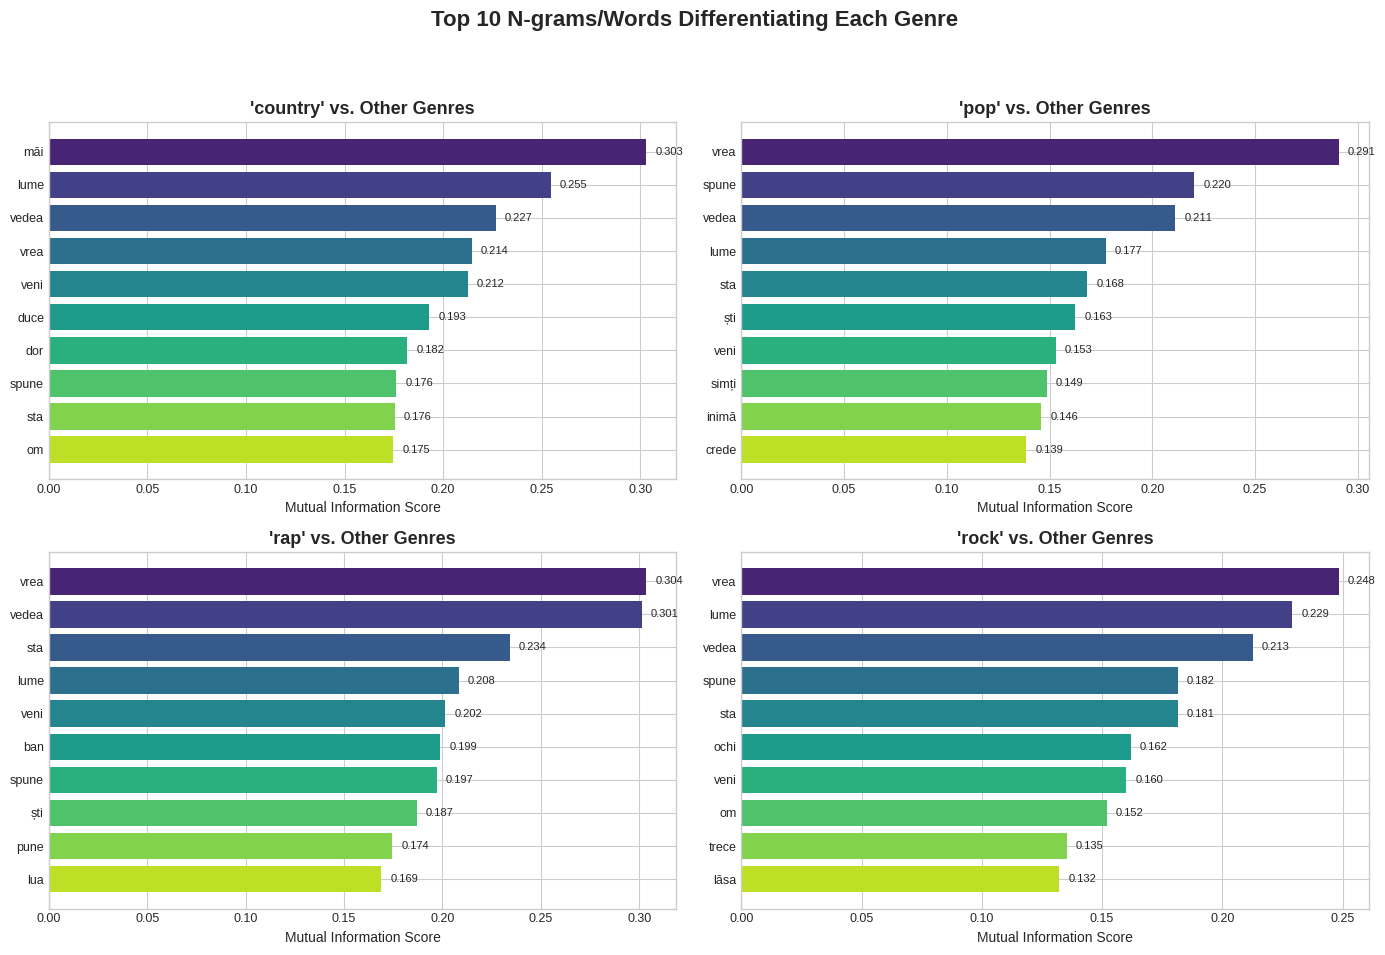

Processing model: nb_tfidf
Example Probabilities (for nb_tfidf, using transformed data): [[4.56935825e-02 4.51605355e-01 4.86823609e-02 4.54018702e-01]
 [2.35007907e-02 1.74185085e-01 6.34191072e-02 7.38895017e-01]
 [4.95578094e-02 7.02978858e-01 2.55262546e-02 2.21937078e-01]
 [1.33381734e-01 2.22189558e-01 2.77424592e-01 3.67004116e-01]
 [9.94529805e-01 1.85095923e-03 4.78428124e-04 3.14080766e-03]]
Class order for nb_tfidf: ['country' 'pop' 'rap' 'rock']

Model: nb_tfidf
Cross-validation Score: 0.8538
Accuracy: 0.8600
Precision: 0.8601
Recall: 0.8600
F1-Score: 0.8592
Classification Report:
               precision    recall  f1-score   support

     country       0.90      0.98      0.94       203
         pop       0.77      0.78      0.77       197
         rap       0.89      0.82      0.85       208
        rock       0.88      0.86      0.87       192

    accuracy                           0.86       800
   macro avg       0.86      0.86      0.86       800
weighted avg       

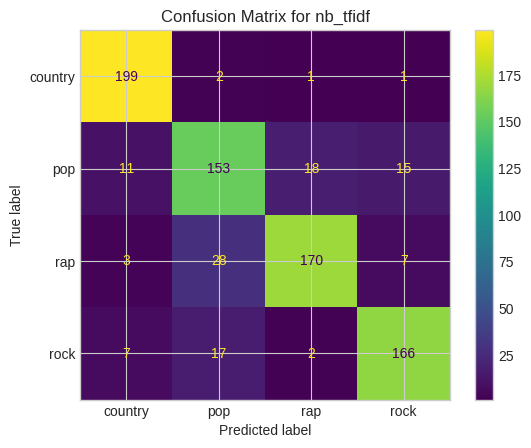

Processing model: svm_tfidf
Example Decision Scores (for svm_tfidf, using manually transformed data): [[-0.2350539   3.25016491  0.78988404  2.17376771]
 [-0.24271215  2.04292388  0.83661095  3.25912632]
 [-0.24498549  3.27245153  0.75170055  2.18303977]
 [-0.21463168  2.08177731  0.82938529  3.23894744]
 [ 3.26899414  0.86153559 -0.26006238  2.02440548]]
Class order for svm_tfidf: ['country' 'pop' 'rap' 'rock']

Model: svm_tfidf
Cross-validation Score: 0.8762
Accuracy: 0.9012
Precision: 0.9006
Recall: 0.9012
F1-Score: 0.9004
Classification Report:
               precision    recall  f1-score   support

     country       0.98      0.99      0.98       203
         pop       0.83      0.79      0.81       197
         rap       0.91      0.88      0.89       208
        rock       0.88      0.95      0.92       192

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



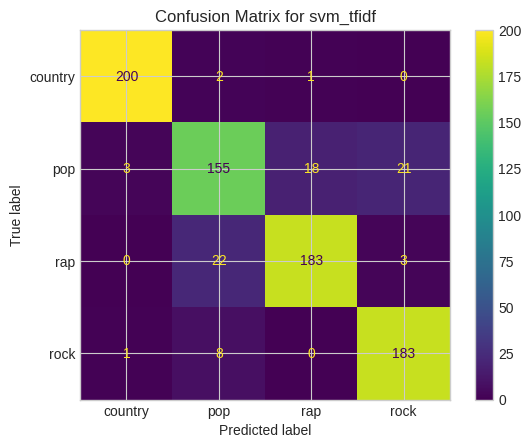

Processing model: ft_mean
Example Probabilities (for ft_mean, using transformed data): [[0.175 0.375 0.16  0.29 ]
 [0.11  0.155 0.245 0.49 ]
 [0.31  0.32  0.095 0.275]
 [0.125 0.22  0.375 0.28 ]
 [1.    0.    0.    0.   ]]
Class order for ft_mean: ['country' 'pop' 'rap' 'rock']

Model: ft_mean
Cross-validation Score: 0.8209
Accuracy: 0.8438
Precision: 0.8416
Recall: 0.8438
F1-Score: 0.8423
Classification Report:
               precision    recall  f1-score   support

     country       0.91      0.97      0.94       203
         pop       0.75      0.72      0.73       197
         rap       0.85      0.86      0.85       208
        rock       0.85      0.83      0.84       192

    accuracy                           0.84       800
   macro avg       0.84      0.84      0.84       800
weighted avg       0.84      0.84      0.84       800



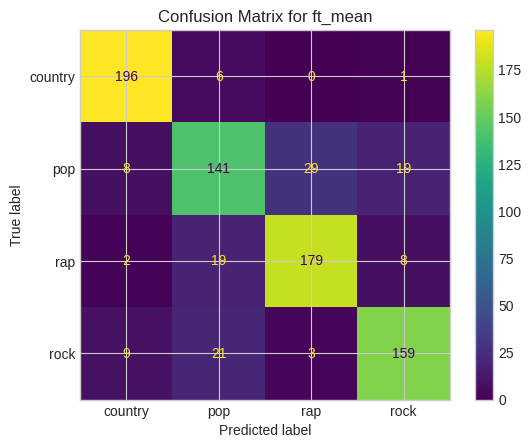

Processing model: ft_tfidf
Example Probabilities (for ft_tfidf, using transformed data): [[0.175 0.375 0.16  0.29 ]
 [0.11  0.155 0.245 0.49 ]
 [0.31  0.32  0.095 0.275]
 [0.125 0.22  0.375 0.28 ]
 [1.    0.    0.    0.   ]]
Class order for ft_tfidf: ['country' 'pop' 'rap' 'rock']

Model: ft_tfidf
Cross-validation Score: 0.8209
Accuracy: 0.8438
Precision: 0.8416
Recall: 0.8438
F1-Score: 0.8423
Classification Report:
               precision    recall  f1-score   support

     country       0.91      0.97      0.94       203
         pop       0.75      0.72      0.73       197
         rap       0.85      0.86      0.85       208
        rock       0.85      0.83      0.84       192

    accuracy                           0.84       800
   macro avg       0.84      0.84      0.84       800
weighted avg       0.84      0.84      0.84       800



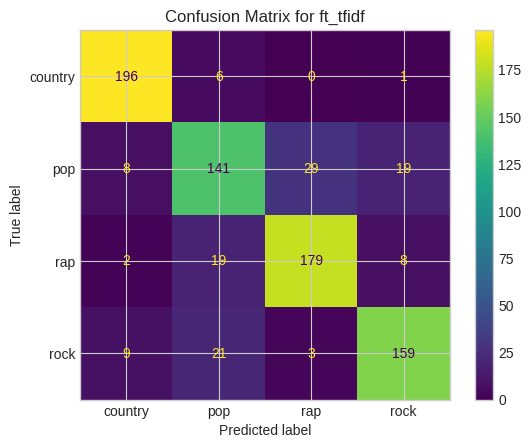

Processing model: svm_ovr_tfidf
Example Decision Scores (for svm_ovr_tfidf, using manually transformed data): [[-1.30833168  0.31750062 -1.58132601 -0.43809493]
 [-1.16419862 -1.02125814 -1.35058466  0.93124344]
 [-1.73468275  1.73274664 -2.19879682 -0.80986226]
 [-1.25056338 -1.16729938 -1.20799556 -0.07019214]
 [ 1.20564642 -1.91974926 -1.75150194 -1.32401078]]
Class order for svm_ovr_tfidf: ['country' 'pop' 'rap' 'rock']

Model: svm_ovr_tfidf
Cross-validation Score: 0.8797
Accuracy: 0.9075
Precision: 0.9065
Recall: 0.9075
F1-Score: 0.9065
Classification Report:
               precision    recall  f1-score   support

     country       0.97      0.99      0.98       203
         pop       0.86      0.79      0.83       197
         rap       0.90      0.90      0.90       208
        rock       0.90      0.95      0.92       192

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91     

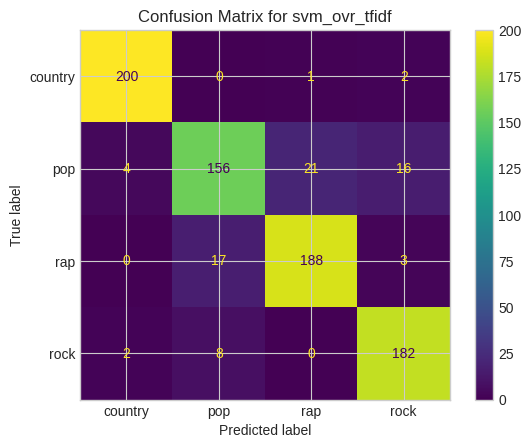

Processing model: logreg_ovr_tfidf
Example Decision Scores (for logreg_ovr_tfidf, using manually transformed data): [[-2.74759616  0.43128953 -2.69293835 -1.82851093]
 [-3.02566698 -1.51196442 -2.25071024  0.22717709]
 [-2.73679272  1.61865406 -4.16324126 -0.93690152]
 [-1.99498209 -1.48308659 -1.69197588 -1.2707118 ]
 [ 2.12414297 -2.86294437 -3.90412294 -2.48335779]]
Class order for logreg_ovr_tfidf: ['country' 'pop' 'rap' 'rock']

Model: logreg_ovr_tfidf
Cross-validation Score: 0.8481
Accuracy: 0.8775
Precision: 0.8772
Recall: 0.8775
F1-Score: 0.8769
Classification Report:
               precision    recall  f1-score   support

     country       0.97      0.98      0.97       203
         pop       0.81      0.76      0.79       197
         rap       0.89      0.88      0.88       208
        rock       0.83      0.90      0.86       192

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88   

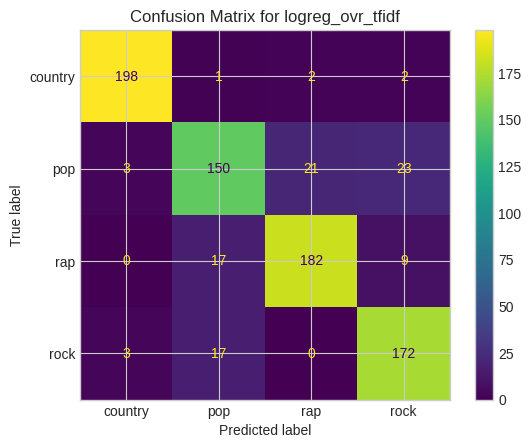

Processing model: svm_ovr_fasttext
Example Decision Scores (for svm_ovr_fasttext, using manually transformed data): [[-1.71671082 -0.49039619 -2.43919507 -0.35080788]
 [-1.88237073 -0.74379938 -1.77818849 -0.36947168]
 [-1.34411997  0.25632639 -2.78051918 -0.64975933]
 [-2.01856573 -0.66770815 -1.3820438  -1.15287066]
 [ 3.21500406 -2.29949644 -2.98627954 -2.45646139]]
Class order for svm_ovr_fasttext: ['country' 'pop' 'rap' 'rock']

Model: svm_ovr_fasttext
Cross-validation Score: 0.8153
Accuracy: 0.8313
Precision: 0.8286
Recall: 0.8313
F1-Score: 0.8290
Classification Report:
               precision    recall  f1-score   support

     country       0.93      0.97      0.95       203
         pop       0.76      0.67      0.71       197
         rap       0.85      0.88      0.87       208
        rock       0.77      0.80      0.79       192

    accuracy                           0.83       800
   macro avg       0.83      0.83      0.83       800
weighted avg       0.83      0.83   

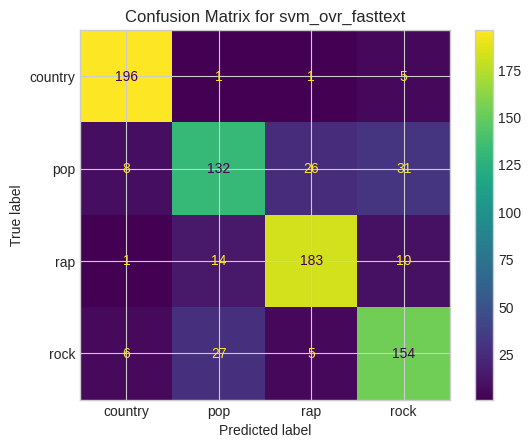

Processing model: logreg_ovr_fasttext
Example Decision Scores (for logreg_ovr_fasttext, using manually transformed data): [[-3.08202717 -0.4584212  -3.66972205 -0.45916923]
 [-3.46696423 -1.35817868 -2.88304204 -0.32196397]
 [-1.61931548 -0.08306483 -5.0976455  -1.59183912]
 [-3.46818396 -1.27021897 -2.00527022 -1.42298391]
 [ 4.79450868 -3.8497396  -5.63036528 -4.20695323]]
Class order for logreg_ovr_fasttext: ['country' 'pop' 'rap' 'rock']

Model: logreg_ovr_fasttext
Cross-validation Score: 0.8122
Accuracy: 0.8200
Precision: 0.8163
Recall: 0.8200
F1-Score: 0.8175
Classification Report:
               precision    recall  f1-score   support

     country       0.91      0.97      0.94       203
         pop       0.73      0.68      0.70       197
         rap       0.85      0.88      0.86       208
        rock       0.77      0.75      0.76       192

    accuracy                           0.82       800
   macro avg       0.81      0.82      0.82       800
weighted avg       0.82 

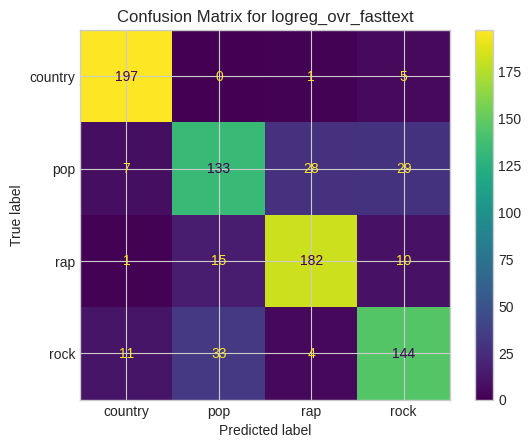

Processing model: extratrees_fasttext
Example Probabilities (for extratrees_fasttext, using transformed data): [[1.77222222e-01 3.68452381e-01 1.68682540e-01 2.85642857e-01]
 [1.55147772e-01 1.63252358e-01 1.69240201e-01 5.12359668e-01]
 [3.29833333e-01 2.90416667e-01 7.66666667e-02 3.03083333e-01]
 [1.16701389e-01 1.91605460e-01 3.61854925e-01 3.29838226e-01]
 [9.99097436e-01 5.32193732e-04 1.85185185e-04 1.85185185e-04]]
Class order for extratrees_fasttext: ['country' 'pop' 'rap' 'rock']

Model: extratrees_fasttext
Cross-validation Score: 0.8253
Accuracy: 0.8475
Precision: 0.8453
Recall: 0.8475
F1-Score: 0.8460
Classification Report:
               precision    recall  f1-score   support

     country       0.92      0.97      0.94       203
         pop       0.77      0.72      0.74       197
         rap       0.84      0.85      0.84       208
        rock       0.86      0.85      0.86       192

    accuracy                           0.85       800
   macro avg       0.84      

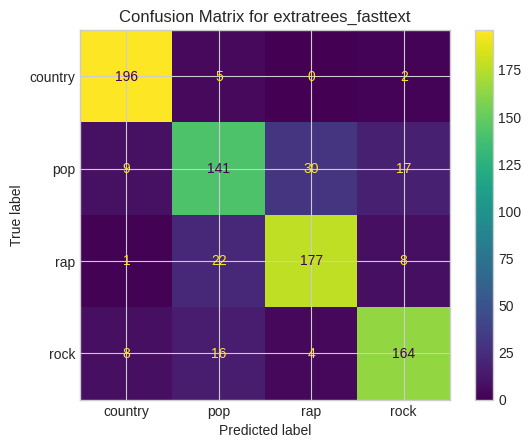

Processing model: extratrees_tfidf
Example Probabilities (for extratrees_tfidf, using transformed data): [[0.12857941 0.49889233 0.12129653 0.25123172]
 [0.12833846 0.26824949 0.20912004 0.394292  ]
 [0.10807919 0.55996658 0.10625674 0.22569749]
 [0.09281712 0.2134114  0.31883366 0.37493783]
 [0.72689059 0.11683984 0.05825894 0.09801063]]
Class order for extratrees_tfidf: ['country' 'pop' 'rap' 'rock']

Model: extratrees_tfidf
Cross-validation Score: 0.8659
Accuracy: 0.8850
Precision: 0.8853
Recall: 0.8850
F1-Score: 0.8851
Classification Report:
               precision    recall  f1-score   support

     country       0.96      0.97      0.96       203
         pop       0.81      0.81      0.81       197
         rap       0.92      0.88      0.90       208
        rock       0.86      0.88      0.87       192

    accuracy                           0.89       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.89      0.89      0.89       800



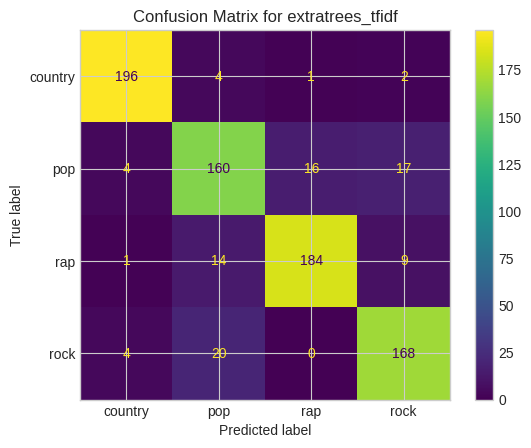


Summary of Cross-validation Scores:
Model                  Score
-------------------  -------
nb_tfidf              0.8538
svm_tfidf             0.8762
ft_mean               0.8209
ft_tfidf              0.8209
svm_ovr_tfidf         0.8797
logreg_ovr_tfidf      0.8481
svm_ovr_fasttext      0.8153
logreg_ovr_fasttext   0.8122
extratrees_fasttext   0.8253
extratrees_tfidf      0.8659


In [ ]:
#EXEPRIMENT:
# la fastText, in loc sa fac doar mean, fac TF-IDF weighted averages
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif


from sklearn.base import BaseEstimator, TransformerMixin

class TFIDFWeightedEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values()))) if word2vec else 0

    def fit(self, X, y=None):
        from sklearn.feature_extraction.text import TfidfVectorizer
        self.tfidf = TfidfVectorizer()
        self.tfidf.fit(X)
        self.idf_dict = dict(zip(self.tfidf.get_feature_names_out(), self.tfidf.idf_))
        return self

    def transform(self, X):
        output = []
        for doc in X:
            words = doc.split()
            vecs = []
            weights = []
            for word in words:
                if word in self.word2vec:
                    vec = self.word2vec[word]
                    weight = self.idf_dict.get(word, 1.0)
                    vecs.append(vec * weight)
                    weights.append(weight)
            if vecs:
                vecs = np.array(vecs)
                output.append(np.mean(vecs, axis=0))
            else:
                output.append(np.zeros(self.dim))
        return np.array(output)

    def get_params(self, deep=True):
        return {"word2vec": self.word2vec}



X = df_balanced[['lyrics', 'repetition_score', 'word_count_normalized']]
y = df_balanced['tag']

text_tfidf = TfidfVectorizer(analyzer='word', max_features=5000)
num_transformer = MinMaxScaler()

preprocessor_tfidf = ColumnTransformer(
    transformers=[
        ('text', text_tfidf, 'lyrics'),
        ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
    ]
)

preprocessor_fasttext = ColumnTransformer(
    transformers=[
        ('text', TFIDFWeightedEmbeddingVectorizer(fasttext_ro), 'lyrics'),
        ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
    ]
)

# from sklearn.feature_selection import mutual_info_classif


# X_text = text_tfidf.fit_transform(df_balanced['lyrics'])
# y_labels = df_balanced['tag']

# mi_scores = mutual_info_classif(X_text, y_labels, discrete_features=True)

# feature_names = text_tfidf.get_feature_names_out()
# mi_series = pd.Series(mi_scores, index=feature_names)
# top_mi = mi_series.sort_values(ascending=False).head(30)

# import matplotlib.pyplot as plt
# top_mi.plot(kind='barh', figsize=(10, 8), title='Top Words by Mutual Information with Genre')
# plt.gca().invert_yaxis()
# plt.show()
print("\n--- Analyzing Top N-grams/Words per Genre (Mutual Information) ---")

# 1. Prepare the text data and labels from your existing X and y
lyrics_data_for_mi = X['lyrics'] # df_balanced['lyrics'] weould also work
genre_labels_for_mi = y          # df_balanced['tag']
unique_genre_list_for_mi = sorted(genre_labels_for_mi.unique())

# 2. Fit the specific text_tfidf vectorizer (defined above by you) on the lyrics data
# This ensures we use the exact same feature generation (incl. ngrams=(1,2), max_features)
X_lyrics_transformed_for_mi = text_tfidf.fit_transform(lyrics_data_for_mi)
feature_names_for_mi = text_tfidf.get_feature_names_out()

# 3. Calculate and Plot Top N-grams for Each Genre
n_genres_for_mi = len(unique_genre_list_for_mi)
top_n_features_val = 10  # Number of top features to display per genre

# Determine subplot layout dynamically
n_cols_plot_val = 2 if n_genres_for_mi > 1 else 1
if n_genres_for_mi > 4 and n_genres_for_mi <=9 : # for 5-9 genres, try 3 columns
    n_cols_plot_val = 3
elif n_genres_for_mi > 9: # for more than 9, maybe 4 columns or adjust figsize
    n_cols_plot_val = 4
n_rows_plot_val = (n_genres_for_mi + n_cols_plot_val - 1) // n_cols_plot_val

plt.style.use('seaborn-v0_8-whitegrid')
fig_mi, all_axes_mi = plt.subplots(n_rows_plot_val, n_cols_plot_val,
                                   figsize=(7 * n_cols_plot_val, 5 * n_rows_plot_val),
                                   squeeze=False) # squeeze=False ensures all_axes_mi is always 2D
all_axes_flat_mi = all_axes_mi.flatten()

genre_specific_top_features_output = {} # To store the Series for each genre

for i_genre, current_genre_val in enumerate(unique_genre_list_for_mi):
    if i_genre >= len(all_axes_flat_mi): # Safety break if not enough subplots
        print(f"Warning: Not enough subplots for genre {current_genre_val}. Max subplots: {len(all_axes_flat_mi)}")
        break

    current_ax_plot = all_axes_flat_mi[i_genre]

    # Create a binary target for the current genre
    y_binary_target_for_genre = (genre_labels_for_mi == current_genre_val).astype(int)

    # Calculate Mutual Information scores
    mi_scores_val = mutual_info_classif(X_lyrics_transformed_for_mi, y_binary_target_for_genre,
                                        discrete_features=True, random_state=42)
    mi_series_val = pd.Series(mi_scores_val, index=feature_names_for_mi)

    # Get the top N features for this genre
    top_mi_for_current_genre = mi_series_val.sort_values(ascending=False).head(top_n_features_val)
    genre_specific_top_features_output[current_genre_val] = top_mi_for_current_genre

    # Plotting
    bar_colors_val = plt.cm.viridis(np.linspace(0.1, 0.9, top_n_features_val))
    bars_collection = current_ax_plot.barh(top_mi_for_current_genre.index, top_mi_for_current_genre.values, color=bar_colors_val)
    current_ax_plot.invert_yaxis()

    current_ax_plot.set_title(f"'{current_genre_val}' vs. Other Genres", fontsize=13, fontweight='semibold')
    current_ax_plot.set_xlabel("Mutual Information Score", fontsize=10)
    current_ax_plot.tick_params(axis='x', labelsize=9)
    current_ax_plot.tick_params(axis='y', labelsize=9) # Adjust if n-grams are too long and overlap

    # Add data labels to bars
    for bar_item_idx, (feature_text, score_value) in enumerate(top_mi_for_current_genre.items()):
        current_ax_plot.text(
            score_value + (top_mi_for_current_genre.max() * 0.015), # x_pos
            bar_item_idx,                                           # y_pos
            f'{score_value:.3f}',                                   # text
            va='center',
            ha='left',
            fontsize=8
        )
    print(f"\nTop {top_n_features_val} features for {current_genre_val} (vs. Others):\n{top_mi_for_current_genre}")

# Hide any unused subplots
for j_ax_idx in range(i_genre + 1, len(all_axes_flat_mi)):
    fig_mi.delaxes(all_axes_flat_mi[j_ax_idx])

fig_mi.suptitle(f"Top {top_n_features_val} N-grams/Words Differentiating Each Genre",
                fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.94]) # Adjust rect to make space for suptitle
plt.show()


pipelines = {
    'nb_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', MultinomialNB())
    ]),
    'svm_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', SVC(kernel='linear', probability=True))
    ]),
    'ft_mean': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', ExtraTreesClassifier(n_estimators=200, random_state=42))
    ]),
    'ft_tfidf': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', ExtraTreesClassifier(n_estimators=200, random_state=42))
    ]),
    'svm_ovr_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', OneVsRestClassifier(SVC(kernel='linear', probability=True)))
    ]),
    'logreg_ovr_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42)))
    ]),
    'svm_ovr_fasttext': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', OneVsRestClassifier(SVC(kernel='linear', probability=True)))
    ]),
    'logreg_ovr_fasttext': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42)))
    ]),
    'extratrees_fasttext': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', ExtraTreesClassifier(n_estimators=300, max_depth=20, random_state=42))
    ]),
    'extratrees_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', ExtraTreesClassifier(n_estimators=300, max_depth=20, random_state=42))
    ]),
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

unique_classes = sorted(y.unique())

for name, pipeline in pipelines.items():
    print(f"Processing model: {name}")
    try:
        score = cross_val_score(pipeline, X_train, y_train, cv=cv, n_jobs=-1).mean()
        results.append((name, score))

        pipeline.fit(X_train, y_train)

        preprocessor = pipeline.named_steps['preprocess']
        clf = pipeline.named_steps['clf']


        X_test_transformed = preprocessor.transform(X_test)

        X_test_transformed_dense = X_test_transformed
        if hasattr(X_test_transformed, "toarray"):
             X_test_transformed_dense = X_test_transformed.toarray()


        decision_scores = None
        if hasattr(clf, 'decision_function'):
            try:
                decision_scores = clf.decision_function(X_test_transformed_dense)
                print(f"Example Decision Scores (for {name}, using manually transformed data): {decision_scores[:5]}")
            except ValueError as e:
                print(f"Could not compute decision_function for {name} using manually transformed data due to ValueError: {e}")
            except Exception as e:
                 print(f"Could not compute decision_function for {name} using manually transformed data due to an unexpected error: {e}")

        elif hasattr(clf, 'predict_proba'):
             try:
                 y_pred_prob = clf.predict_proba(X_test_transformed)
                 print(f"Example Probabilities (for {name}, using transformed data): {y_pred_prob[:5]}")
             except Exception as e:
                 print(f"Could not compute predict_proba for {name} using transformed data: {e}")


        model_classes = None
        if hasattr(clf, 'classes_'):
            model_classes = clf.classes_
        elif hasattr(clf, 'estimators_') and clf.estimators_:

            if hasattr(clf.estimators_[0], 'classes_'):
                 model_classes = clf.estimators_[0].classes_

        if model_classes is not None:
            print(f"Class order for {name}: {model_classes}")
        else:
             print(f"Could not determine class order for {name}")


        y_pred = pipeline.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        print(f"\nModel: {name}")
        print(f"Cross-validation Score: {score:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

        cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
        disp.plot()
        plt.title(f"Confusion Matrix for {name}")
        plt.show()

    except Exception as e:
        print(f"An error occurred during processing of pipeline {name}: {e}")
        results.append((name, 'Error'))


print("\nSummary of Cross-validation Scores:")
print(tabulate(results, headers=['Model', 'Score'], floatfmt=".4f"))

Processing model: nb_tfidf
Pipeline steps: ['preprocess', 'clf']
Using preprocessor_tfidf style parameters (based on 'text' transformer name in config).
Hyperparameter tuning for nb_tfidf using GridSearchCV...
Parameter grid: {'preprocess__text__tfidfvectorizer__max_features': [3000, 5000], 'preprocess__text__tfidfvectorizer__ngram_range': [(1, 1), (1, 2)], 'preprocess__text__selectkbest__k': [500, 1000, 1500], 'clf__alpha': [0.1, 0.5, 1.0]}
Fitting 3 folds for each of 36 candidates, totalling 108 fits


Datele de ieșire de afișat au fost trunchiate la ultimele 5000 linii.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and m

Best Score for nb_tfidf: 0.8334
Best Params for nb_tfidf: {'clf__alpha': 0.1, 'preprocess__text__selectkbest__k': 1500, 'preprocess__text__tfidfvectorizer__max_features': 3000, 'preprocess__text__tfidfvectorizer__ngram_range': (1, 2)}

Model: nb_tfidf (Post-tuning or Default Fit)
Cross-validation Score (from GridSearchCV best_score_): 0.8334
Test Accuracy: 0.8512
Test Precision: 0.8531
Test Recall: 0.8512
Test F1-Score: 0.8500
Classification Report:
               precision    recall  f1-score   support

     country       0.96      0.98      0.97       200
         pop       0.76      0.73      0.75       200
         rap       0.80      0.92      0.85       200
        rock       0.89      0.78      0.83       200

    accuracy                           0.85       800
   macro avg       0.85      0.85      0.85       800
weighted avg       0.85      0.85      0.85       800



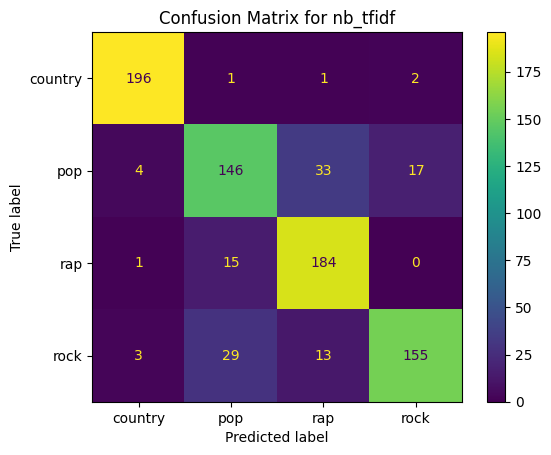


Top 1500 features selected by SelectKBest for nb_tfidf:
Top selected features and their Information Gain (Mutual Info) scores:
     feature  mutual_info_score
1411    vrea           0.650221
1339   vedea           0.585390
636     lume           0.535141
1135   spune           0.477754
1142     sta           0.463581
1346    veni           0.447552
1492     ști           0.377675
816       om           0.353060
360     duce           0.347442
1256   trece           0.329160
Processing model: svm_tfidf
Pipeline steps: ['preprocess', 'clf']
Using preprocessor_tfidf style parameters (based on 'text' transformer name in config).
Hyperparameter tuning for svm_tfidf using GridSearchCV...
Parameter grid: {'preprocess__text__tfidfvectorizer__max_features': [3000, 5000], 'preprocess__text__selectkbest__k': [500, 1000], 'clf__C': [0.1, 1, 10]}
Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [ ]:
#EXPERIMENT: optimizing parameters with automatic choosing and observing data with information gain
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif



class TFIDFWeightedEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec, tfidf_ngram_range=(1,1), tfidf_max_features=None):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values()))) if word2vec else 0
        self.tfidf_ngram_range = tfidf_ngram_range
        self.tfidf_max_features = tfidf_max_features


    def fit(self, X, y=None):

        self.tfidf = TfidfVectorizer(ngram_range=self.tfidf_ngram_range, max_features=self.tfidf_max_features)
        self.tfidf.fit(X)
        self.idf_dict = dict(zip(self.tfidf.get_feature_names_out(), self.tfidf.idf_))
        return self

    def transform(self, X):
        output = []
        for doc in X:
            words = self.tfidf.build_analyzer()(doc)
            vecs = []
            doc_vec_sum = np.zeros(self.dim)
            total_weight = 0
            for word in words:
                if word in self.word2vec and word in self.idf_dict:
                    vec = self.word2vec[word]
                    weight = self.idf_dict.get(word, 1.0) # Default to 1.0 if word not in IDF
                    doc_vec_sum += vec * weight
                    total_weight += weight
            if total_weight > 0:
                output.append(doc_vec_sum / total_weight)
            else:
                output.append(np.zeros(self.dim))
        return np.array(output)

    def get_params(self, deep=True):
        return {"word2vec": self.word2vec,
                "tfidf_ngram_range": self.tfidf_ngram_range,
                "tfidf_max_features": self.tfidf_max_features}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


X = df_balanced[['lyrics', 'repetition_score', 'word_count_normalized']]
y = df_balanced['tag']

# This pipeline can have its steps tuned.
text_pipeline_tfidf = make_pipeline(
    TfidfVectorizer(analyzer='word'), # max_features will be tuned
    SelectKBest(score_func=mutual_info_classif) # k will be tuned
)

num_transformer = MinMaxScaler()

preprocessor_tfidf = ColumnTransformer(
    transformers=[
        ('text', text_pipeline_tfidf, 'lyrics'), # 'text' is the name of this transformer
        ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
    ]
)

preprocessor_fasttext = ColumnTransformer(
    transformers=[

        ('text_ft', TFIDFWeightedEmbeddingVectorizer(fasttext_ro), 'lyrics'),
        ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
    ]
)


pipelines = {
    'nb_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', MultinomialNB())
    ]),
    'svm_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', SVC(kernel='linear', probability=True))
    ]),
    'logreg_ovr_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')))
    ]),
    'extratrees_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', ExtraTreesClassifier(random_state=42))
    ]),
     'ft_mean_extratrees': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', ExtraTreesClassifier(random_state=42))
    ]),
    'svm_ovr_fasttext': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', OneVsRestClassifier(SVC(kernel='linear', probability=True)))
    ]),
    'logreg_ovr_fasttext': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')))
    ]),
}

param_grids = {
    'nb_tfidf': {
        'preprocess__text__tfidfvectorizer__max_features': [3000, 5000],
        'preprocess__text__tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
        'preprocess__text__selectkbest__k': [500, 1000, 1500],
        'clf__alpha': [0.1, 0.5, 1.0]
    },
    'svm_tfidf': {
        'preprocess__text__tfidfvectorizer__max_features': [3000, 5000],
        'preprocess__text__selectkbest__k': [500, 1000],
        'clf__C': [0.1, 1, 10]
    },
    'logreg_ovr_tfidf': {
        'preprocess__text__tfidfvectorizer__max_features': [3000, 5000],
        'preprocess__text__selectkbest__k': [500, 1000],
        'clf__estimator__C': [0.1, 1, 10]
    },
    'extratrees_tfidf': {
        'preprocess__text__tfidfvectorizer__max_features': [3000, 5000],
        'preprocess__text__selectkbest__k': [500, 1000],
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [10, 20, None]
    },

    'ft_mean_extratrees': {
        'preprocess__text_ft__tfidf_ngram_range': [(1,1), (1,2)],
        'preprocess__text_ft__tfidf_max_features': [None, 5000],
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [10, 20, None]
    },
    'svm_ovr_fasttext': {
        'preprocess__text_ft__tfidf_max_features': [None, 5000],
        'clf__estimator__C': [0.1, 1, 10],
    },
    'logreg_ovr_fasttext': {
        'preprocess__text_ft__tfidf_max_features': [None, 5000],
        'clf__estimator__C': [0.1, 1, 10],
    },
}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
results_summary = []
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # Reduced splits for faster demo; use 5 for real runs

unique_classes = sorted(y.unique())

for name, pipeline_obj in pipelines.items():
    print(f"Processing model: {name}")
    print("Pipeline steps:", [step for step, _ in pipeline_obj.steps])

    # Check if specific preprocessor is used to access correct param_grid keys
    # This example assumes 'preprocess' is always the name of the preprocessor step in the main pipeline
    if 'preprocess' in pipeline_obj.named_steps:
      preprocessor_config = pipeline_obj.named_steps['preprocess']
    # Access the initial configuration of transformers (list of tuples: name, transformer, columns)
    # This 'transformers' attribute is the one passed to the constructor.
      configured_transformer_names = [trans_name for trans_name, _, _ in preprocessor_config.transformers]
      if 'text' in configured_transformer_names:
          print("Using preprocessor_tfidf style parameters (based on 'text' transformer name in config).")
      elif 'text_ft' in configured_transformer_names:
          print("Using preprocessor_fasttext style parameters (based on 'text_ft' transformer name in config).")
      else:
          print("Preprocessor style not determined by 'text' or 'text_ft' transformer name in config.")



    current_param_grid = param_grids.get(name, {})
    if not current_param_grid:
        print(f"No parameter grid defined for {name}. Fitting with default parameters.")
        try:
            pipeline_obj.fit(X_train, y_train)
            best_pipeline = pipeline_obj
            best_score = cross_val_score(pipeline_obj, X_train, y_train, cv=cv, n_jobs=-1, scoring='accuracy').mean()
            best_params = "Defaults"
            results_summary.append((name, best_score, best_params))

        except Exception as e:
            print(f"An error occurred during basic fitting of pipeline {name}: {e}")
            results_summary.append((name, 'Error', str(e)))
            continue # Skip to next pipeline
    else:
        print(f"Hyperparameter tuning for {name} using GridSearchCV...")
        print(f"Parameter grid: {current_param_grid}")

        grid_search = GridSearchCV(estimator=pipeline_obj, param_grid=current_param_grid,
                                   cv=cv, scoring='accuracy', n_jobs=-1, verbose=1) # Use 'f1_weighted' or other relevant metric
        try:
            grid_search.fit(X_train, y_train)
            best_score = grid_search.best_score_
            best_params = grid_search.best_params_
            best_pipeline = grid_search.best_estimator_
            results_summary.append((name, best_score, best_params))
            print(f"Best Score for {name}: {best_score:.4f}")
            print(f"Best Params for {name}: {best_params}")

        except Exception as e:
            print(f"An error occurred during GridSearchCV for pipeline {name}: {e}")
            import traceback
            traceback.print_exc()
            results_summary.append((name, 'Error during GridSearchCV', str(e)))
            continue # Skip to next pipeline

    # Evaluate the best_pipeline (either from GridSearchCV or default fit)
    try:
        y_pred = best_pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        print(f"\nModel: {name} (Post-tuning or Default Fit)")
        if isinstance(best_params, dict): # if GridSearchCV was run
             print(f"Cross-validation Score (from GridSearchCV best_score_): {best_score:.4f}")
        else: # if only cross_val_score on default was run
             print(f"Cross-validation Score (manual): {best_score:.4f}")
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test Precision: {precision:.4f}")
        print(f"Test Recall: {recall:.4f}")
        print(f"Test F1-Score: {f1:.4f}")
        print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0, labels=unique_classes, target_names=unique_classes))

        cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
        disp.plot()
        plt.title(f"Confusion Matrix for {name}")
        plt.show()

        # --- To see which features are the best (for TF-IDF pipelines with SelectKBest) ---
        if name.endswith('_tfidf') and 'preprocess' in best_pipeline.named_steps:
            preprocessor_step = best_pipeline.named_steps['preprocess']
            # The ColumnTransformer's 'text' transformer is our text_pipeline_tfidf (a make_pipeline)
            text_transformer_pipeline = preprocessor_step.named_transformers_['text']

            # Get the TfidfVectorizer and SelectKBest steps from this inner pipeline
            tfidf_vectorizer_step = text_transformer_pipeline.named_steps['tfidfvectorizer']
            select_k_best_step = text_transformer_pipeline.named_steps['selectkbest']

            if hasattr(tfidf_vectorizer_step, 'get_feature_names_out') and hasattr(select_k_best_step, 'get_support'):
                all_feature_names = tfidf_vectorizer_step.get_feature_names_out()
                selected_mask = select_k_best_step.get_support()
                selected_feature_names = all_feature_names[selected_mask]
                print(f"\nTop {len(selected_feature_names)} features selected by SelectKBest for {name}:")
                # print(selected_feature_names[:20]) # Print top 20 selected features

                # If you want scores of these features (mutual_info_classif scores)
                # Ensure SelectKBest has stored scores_ attribute after fitting
                if hasattr(select_k_best_step, 'scores_'):
                    selected_feature_scores = select_k_best_step.scores_[selected_mask]
                    # Create a DataFrame of features and their scores
                    features_df = pd.DataFrame({
                        'feature': selected_feature_names,
                        'mutual_info_score': selected_feature_scores
                    }).sort_values(by='mutual_info_score', ascending=False)
                    print("Top selected features and their Information Gain (Mutual Info) scores:")
                    print(features_df.head(10))


    except Exception as e:
        print(f"An error occurred during evaluation of pipeline {name}: {e}")
        import traceback
        traceback.print_exc()


print("\nSummary of Best Cross-validation Scores and Parameters:")
# results_summary now contains (name, best_cv_score, best_params_dict_or_error_string)
# We need to format best_params if it's a dict for tabulate
formatted_results = []
for res_name, res_score, res_params in results_summary:
    if isinstance(res_params, dict):
        # Convert dict to a string representation for tabulate
        params_str = '; '.join([f"{k.split('__')[-1]}={v}" for k, v in res_params.items()])
    else:
        params_str = str(res_params) # Handles "Defaults" or error messages
    formatted_results.append((res_name, res_score, params_str))

print(tabulate(formatted_results, headers=['Model', 'Best CV Score', 'Best Params'], floatfmt=".4f", tablefmt="grid"))

In [ ]:
class RomanianMeanEmbeddingVectorizer:
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words.split() if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    def get_params(self, deep=True):
         return {"word2vec": self.word2vec}



X = df_balanced[['lyrics', 'repetition_score', 'word_count_normalized']]
y = df_balanced['tag']

text_tfidf = TfidfVectorizer(analyzer='word', max_features=5000)
num_transformer = MinMaxScaler()

preprocessor_tfidf = ColumnTransformer(
    transformers=[
        ('text', text_tfidf, 'lyrics'),
        ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
    ]
)

preprocessor_fasttext = ColumnTransformer(
    transformers=[
        ('text', RomanianMeanEmbeddingVectorizer(fasttext_ro), 'lyrics'),
        ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
    ]
)

# num_transformer = StandardScaler()

# preprocessor_tfidf = ColumnTransformer(
#     transformers=[
#         ('text', text_tfidf, 'lyrics'),
#         ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
#     ]
# )

# preprocessor_fasttext = ColumnTransformer(
#     transformers=[
#         ('text', RomanianMeanEmbeddingVectorizer(fasttext_ro), 'lyrics'),
#         ('num', num_transformer, ['repetition_score', 'word_count_normalized'])
#     ]
# )

pipelines = {
    'nb_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', MultinomialNB())
    ]),
    'svm_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', SVC(kernel='linear'))
    ]),
    'ft_mean': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', ExtraTreesClassifier(n_estimators=200))
    ]),
    'ft_tfidf': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', ExtraTreesClassifier(n_estimators=200))
    ]),
    'svm_ovr_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', OneVsRestClassifier(SVC(kernel='linear')))
    ]),
    'logreg_ovr_tfidf': Pipeline([
        ('preprocess', preprocessor_tfidf),
        ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000)))
    ]),
    'svm_ovr_fasttext': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', OneVsRestClassifier(SVC(kernel='linear')))
    ]),
    'logreg_ovr_fasttext': Pipeline([
        ('preprocess', preprocessor_fasttext),
        ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000)))
    ])
}


results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for name, pipeline in pipelines.items():
    score = cross_val_score(pipeline, X, y, cv=cv).mean()
    results.append((name, score))
    pipeline.fit(X, y)
    y_pred = pipeline.predict(X_test)
    print(f"\nModel: {name}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


print(tabulate(results, headers=['Model', 'Score'], floatfmt=".4f"))


In [ ]:
best_model = pipelines['svm_tfidf']  # Change this if you want to use another model

best_model.fit(X, y)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=5000),
                                                  'lyrics'),
                                                 ('num', MinMaxScaler(),
                                                  ['repetition_score',
                                                   'word_count_normalized'])])),
                ('clf', SVC(kernel='linear', probability=True))])

In [ ]:
joblib.dump(best_model, 'model.joblib')

['model.joblib']

In [ ]:
def predict_genre(lyrics, model_name, pipelines, word_count, repetition_score ):
    """
    Predicts the genre of a given lyrics string using the specified model.

    Parameters:
    - lyrics (str): The song lyrics to classify.
    - model_name (str): The key corresponding to the trained model in `pipelines`.
    - pipelines (dict): A dictionary containing trained models.
    - tfidf (TfidfVectorizer, optional): The trained TF-IDF vectorizer used during preprocessing.
    - fasttext_ro (dict, optional): The FastText word embeddings used during preprocessing.

    Returns:
    - str: The predicted genre.
    """
    if model_name not in pipelines:
        raise ValueError(f"Model '{model_name}' not found in available pipelines.")

    model = pipelines[model_name]

    new_data = pd.DataFrame({'lyrics': [lyrics],
                            'repetition_score': [repetition_score],
                            'word_count_normalized': [word_count]})

    # X_input = model.named_steps['preprocess'].transform(new_data) # Use the pipeline's preprocessor
    # #X_input = preprocessor_tfidf.transform(new_data)
    # print(f"Shape of X_input: {X_input.shape}")
    # print(f"Model n_features_in_: {model.named_steps['clf'].n_features_in_}")

    # # Predict the genre
    prediction = model.predict(new_data)

    return prediction[0]


In [ ]:
from collections import Counter

nlp_ro = spacy.load("ro_core_news_sm")

def calculate_repetition_score(lyrics):
    words = lyrics.split()
    total_words = len(words)
    word_counts = Counter(words)
    repeated_word_count = sum(count - 1 for count in word_counts.values() if count > 1)
    repetition_score = repeated_word_count / total_words if total_words > 0 else 0
    return repetition_score

def calculate_word_count_normalized(lyrics):
    words = lyrics.split()
    word_count = len(words)
    scaler = StandardScaler()
    word_count_normalized = scaler.fit_transform([[word_count]])[0][0]
    return word_count_normalized

def lemmatize_text(text):
    doc = nlp_ro(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    return " ".join(lemmatized_tokens)




#new_lyrics = lemmatize_text("cine aude gura mea cine aude gura mea lasă vinul și nu bea și vine la gura mea cine aude glasul meu cine aude glasul meu lasă vinul făgădău și vine la glasul meu toate câte sunt pe lume toate câte sunt pe lume gura mea toate le spune gura mea toate le spune scripcaru-i cu scripca lui scripcaru-i cu scripca lui eu cu para focului eu cu para focului când eram pe vremea mea când eram pe vremea mea nici scripcă nu-mi trebuia nici scripcă nu-mi trebuia scripcă era gura mea scripcă era gura mea și cântam mereu din ea și cântam mereu din ea că scripca e o doagă spartă că scripca e o doagă spartă gura cu cântecu-i dată gura cu cântecu-i dată și la scripcă-i trebuie arc și la scripcă-i trebuie arc eu doina din dor o fac eu doina din dor o fac hai la joc picioare, măi! hai la joc picioare, măi! voi cu mine, eu cu voi voi cu mine, eu cu voi eu vă dau să vă îndreptați eu vă dau să vă îndreptați voi mai tare vă strâmbați voi mai tare vă strâmbați toate câte sunt pe lume toate câte sunt pe lume gura mea toate le spune gura mea toate le spune scripcaru-i cu scripca lui scripcaru-i cu scripca lui eu cu para focului eu cu para focului")
#new_lyrics = lemmatize_text("yeah yeah yeah aha aha aha am încercat mult timp să fiu băiatul bun aha până am realizat că de fapt doar mă consum doar mă consum droguri consum greșeli mi le asum îmi asum tot ce spun am încercat mult timp să fiu băiatul bun okay până am realizat că de fapt doar mă consum okay doar mă consum yeah droguri consum greșeli mi le asum îmi asum tot ce spun du mă înapoi în zilele în care nu străluceam așa de tare acum sunt propriul meu soare du mă înapoi în zilele în care oamenii aveau mai mult respect demnitate și onoare acum toți schimbă echipe vor război cu noi am armele pregătite am ținte în minte dinamite în cuvinte frații mei sunt cobre pe tobe te fac din câteva vorbe fac din studio-uri catacombe micobre nu mi pasă de premii sau titluri le semnez sfârșitu io nu am final zici că fac piesă cu infinitu yeah yeah și dacă clachez mă ridic și o fac din nou urlu în microfon de zici că-i ultimu meu show tot răul din trecut pentru binele din viitor toate fostele într-o cameră cântând okay okay în cor i’m sorry bae nu vorbesc de mâncare când zic că azi e cheat day trage prea mult kim k uită-te la mine dacă tot vorbim îmi amintesc cum ne juram că o reușim acum doar ne înjurăm și ne tot mințim avem un trecut ne purtăm de parcă nu ni-l amintim nu suntem genul să ne lăudăm cu ce avem yeah aștept să mor ca să iasă albumu post-mortem nu-mi sta pe cap fă ce mă vezi totem ai crezut că e un win de fapt e tot l pune banii jos în fața mea am pus în versuri viața mea nu încerc să par altcineva doar încerc să fac altceva am ales să fiu eu nu știu ce problemă ai tu nu ne jucăm remi doar că am un atu am intrat în jocu ăsta m-am lovit de nu și nu și nu știi cum toți vor să stea cu tine acum nu e o pasiune e mai mult o misiune și o să o fac până ating nivelul suprem de înțelepciune am încercat mult timp să fiu băiatul bun okay până am realizat că de fapt doar mă consum yeah doar mă consum droguri consum greșeli mi le asum îmi asum tot ce spun am încercat mult timp să fiu băiatul bun până am realizat că de fapt doar mă consum doar mă consum yeah droguri consum greșeli mi le asum îmi asum tot ce spun")
new_lyrics = lemmatize_text("aș vrea să fiu paharul care-ți atinge buzele aș vrea să fiu și strada care îți simte tălpile încerc și cu privirea să îți înlătur hainele dar numai lasă-te dar numai lasă-te du-te ba nu pleca de fapt tu știi că aș vrea să mă strângi în brațe mai tare fugi dar nu repede să nu-mi scapi printre degete ajungem tot mai aproape hai zi-mi ce-ți cântă dragostea atunci când mă privești așa ce dacă-i piesa mea tu o să mă săruți în ritmul potrivit din cum îți cântă dragostea din cum-ți dansează inima voi știi că-i piesa mea și c-o să vrei s-o pui și mâine pe repeat hai zi-mi cum e la tine atunci când vrei pe cineva și când iubirea vine fără să te aștepți la ea aș vrea să fiu și ploaia să cad ușor pe trupul tău dar numai lasă-te dar numai lasă-te du-te ba nu pleca de fapt tu știi că aș vrea să mă strângi în brațe mai tare fugi dar nu repede să nu-mi scapi printre degete ajungem tot mai aproape hai zi-mi ce-ți cântă dragostea atunci când mă privești așa ce dacă-i piesa mea tu o să mă săruți în ritmul potrivit din cum îți cântă dragostea din cum-ți dansează inima voi știi că-i piesa mea și c-o să vrei s-o pui n-aș vrea să-ți spun nici multe cuvinte dulci pe praf de dor și când se lasă luna să-mi zâmbești plin de culori și tot ce-nseamnă suflet să-mi topesc de palma ta ce-ți cântă dragostea hai zi-mi ce-ți cântă dragostea atunci când mă privești așa ce dacă-i piesa mea tu o să mă săruți în ritmul potrivit din cum îți cântă dragostea din cum-ți dansează inima voi știi că-i piesa mea și c-o să vrei s-o pui și mâine pe repeat")
# new_lyrics = lemmatize_text("dece radica intunecarea s-or hi vinitu dzicind urlindu cei crudz tvorebnici zlobivi oblicind ferman-olac preste paduri ce-n veci s-or tinsu si or ascunsu dupre reci imbre cu doao coarne cu colti de hiara preste munti i-io ma voiu arata")
repetition_score = calculate_repetition_score(new_lyrics)

word_count = calculate_word_count_normalized(new_lyrics)



In [ ]:
predicted_genre = predict_genre(new_lyrics, "svm_tfidf", pipelines, word_count, repetition_score)
print(f"Predicted genre: {predicted_genre}")


Predicted genre: pop
